# May Code Pudding: Bias Detection

## Introduction:

---

This project explores the detection of textual **bias** in news articles using a combination of expert-labeled datasets and **natural language processing** techniques. The primary dataset used is **SG2** from the **BABE** (Bias Annotations By Experts) corpus, which contains over 3,000 sentences labeled by domain experts as either *biased* or *non-biased*. Supplementary data includes a **bias word lexicon** and headlines datasets labeled as biased or neutral.

The goal is to develop a machine learning model that can accurately predict whether a given **sentence or headline** exhibits bias. To achieve this, the project combines **TF-IDF vectorization** of text with handcrafted features such as the number of matched **bias-related words**. The resulting model is trained using **logistic regression** and evaluated with **AUC-ROC** and accuracy metrics.

This notebook includes detailed **exploratory data analysis (EDA)**, a custom preprocessing pipeline, and a test phase on new, unseen Wikipedia headlines to assess generalization. Visualizations help explore the **distribution of bias** and the relationship between lexical signals and human-labeled bias.

The project is designed to serve as both a **research exploration** into bias detection and a **reproducible framework** for evaluating bias in text-based datasets.

---

The goal of this project is to detect and quantify **bias in Wikipedia articles** by training models on labeled media bias data. To accomplish this, we use two datasets—**MBIC** and **SG1**—each containing news articles labeled for bias. The project follows a **step-by-step process** aligned with the task requirements to ensure clarity and reproducibility.

We begin with **exploratory data analysis**, comparing the two datasets. This includes checking for **label agreement**, identifying **discrepancies between MBIC and SG1**, and analyzing the **political leanings** associated with each label. After this, we **preprocess the data** by removing ambiguous entries, mapping bias labels to numeric values, and engineering a **lexicon-based bias indicator**.

Next, we train two separate **logistic regression models** using **TF-IDF vectorized text features** and numeric indicators such as **lexicon match count**. We evaluate the models using **AUC-ROC** and classification metrics to determine how well each performs in detecting bias.

Once validated, the models are applied to **new data**—scraped Wikipedia articles. Each model makes **sentence-level bias predictions**, which are then aggregated to compute an overall **bias score** per article. This allows us to estimate how biased a given article is based on its content.

Finally, we compare **bias scores across topics** to identify which types of articles are more or less likely to be labeled as biased. This supports conclusions about the **shared characteristics of biased content** and differences in how each model interprets bias.

---

## Getting Packages and Reading Data:

In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_auc_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_colwidth", None)

In [2]:
dataset_path = os.path.join(os.pardir, "datasets")

df_sg2 = pd.read_csv(os.path.join(dataset_path, "final_labels_SG2.csv"), sep=";")
df_lex = pd.read_excel(os.path.join(dataset_path, "bias_word_lexicon.xlsx"))

df_bias = pd.read_csv(os.path.join(dataset_path, "news_headlines_usa_biased.csv"))
df_neutral = pd.read_csv(os.path.join(dataset_path, "news_headlines_usa_neutral.csv"))

This step loads the datasets used to train and test a machine learning model that detects bias in text.

**First**, the code sets up a path to the `datasets` folder, which contains all the necessary data files. This path makes the project easy to run on any computer.

**Next**, the `SG2` dataset is loaded. This file contains over 3,000 news sentences that have already been labeled by expert reviewers as either biased or non-biased. The labels help the model learn from real examples of political or ideological bias.

**The `bias_word_lexicon` file** is also loaded. It contains a list of words that are commonly associated with biased language. This list is used later to create a feature that counts how many biased words appear in each sentence.

**Two additional datasets** are included: one full of headlines known to be biased, and another full of neutral ones. These headlines help provide more context to each sentence and give the model more examples of how bias can appear in shorter text.

The project uses only the `SG2` dataset (and not `SG1` or `MBIC`) because:

- It is the largest of the three versions, containing 3,700 labeled sentences.
- All sentences were labeled by expert annotators (not crowdsourced).
- It contains a roughly even mix of biased and non-biased examples.

The original source for these datasets is the BABE (Bias Annotations By Experts) project, which provides high-quality bias labels from trained experts. Using `SG2` ensures the model is trained on reliable, expert-reviewed examples.

Source:  
https://www.kaggle.com/datasets/timospinde/babe-media-bias-annotations-by-experts  
https://aclanthology.org/2021.findings-emnlp.101.pdf

## Getting Data Merged:

In [3]:
df_sg2.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",https://www.foxnews.com/entertainment/australian-actress-yael-stone-giving-up-green-card-fight-climate-change,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful.""",https://www.alternet.org/2020/06/law-and-order-is-a-debased-concept-used-to-cover-up-right-wing-crime-and-depravity-heres-why/,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views.",https://www.nbcnews.com/news/latino/after-stephen-miller-s-white-nationalist-views-outed-latinos-ask-n1096071,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,"...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability.",https://www.alternet.org/2019/07/fox-news-has-gone-so-deep-into-white-nationalism-that-donald-trump-now-believes-its-how-hell-win-in-2020/,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,"[Black Lives Matter] is essentially a non-falsifiable religious cult that sets itself specifically against Christianity, just like the French Revolution did.",http://feedproxy.google.com/~r/breitbart/~3/-vHhfcwC74U/,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']


This table shows a preview of the `SG2` dataset, which contains news sentences labeled for political or ideological bias. Each row represents a single sentence along with related information that helps the model learn how bias appears in text.

**Key columns in this dataset include:**

- ``text``: The full sentence taken from a news article.
- ``news_link``: The original article link where the sentence was found.
- ``outlet``: The news source that published the article (e.g., Fox News, MSNBC).
- ``topic``: The main issue being discussed, such as gun control or climate change.
- ``type``: The political leaning of the outlet (e.g., left, right). This is sometimes missing.
- ``label_bias``: The expert label showing whether the sentence is biased or non-biased.
- ``label_opinion``: A description of how factual or opinionated the sentence is.
- ``biased_words``: A list of specific words in the sentence that may indicate bias.

These columns help the model understand not just what is being said, but also how it is said — whether it leans toward opinion, uses emotionally charged words, or aligns with a political stance.

In [4]:
df_sg2["label_bias"].value_counts()

label_bias
Non-biased      1863
Biased          1810
No agreement       1
Name: count, dtype: int64

This dataset contains a nearly even split between biased and non-biased sentences:

- ``Non-biased``: 1,863 sentences
- ``Biased``: 1,810 sentences
- ``No agreement``: 1 sentence

The ``No agreement`` label means that expert annotators could not reach a consensus on whether the sentence was biased or not. Since this only occurs once, it can be removed to keep the dataset clean and focused.

Having a balanced number of biased and non-biased examples helps the model learn more fairly, without being biased itself toward one category.

In [5]:
df_sg2 = df_sg2[df_sg2["label_bias"] != "No agreement"]
df_sg2["label"] = df_sg2["label_bias"].map({"Biased": 1, "Non-biased": 0})
df_sg2.drop(columns="label_bias", inplace=True)

This step cleans and simplifies the labels used for training the model.

- The first line removes the single row where there was ``No agreement`` among expert annotators.
- The second line creates a new column called ``label`` that converts the text labels into numbers:
  - ``Biased`` becomes ``1``
  - ``Non-biased`` becomes ``0``
- The original ``label_bias`` column is then deleted to avoid duplication.

This makes the dataset easier for a machine learning model to understand, since most models expect numeric input rather than text labels.

In [6]:
df_sg2["label"].value_counts()

label
0    1863
1    1810
Name: count, dtype: int64

All fixed!

In [7]:
bias_words_set = set(df_lex.iloc[:, 0].str.lower().dropna())

df_sg2["lexicon_match_count"] = df_sg2["text"].apply(
    lambda x: sum(word in bias_words_set for word in str(x).lower().split())
)

In [8]:
df_bias["label"] = 1
df_neutral["label"] = 0
headline_full = pd.concat([df_bias, df_neutral], ignore_index=True)

df_sg2 = df_sg2.merge(
    headline_full[["url", "title"]], left_on="news_link", right_on="url", how="left"
)

df_sg2["combined_text"] = df_sg2.apply(
    lambda row: (
        f"{row['title']}. {row['text']}" if pd.notnull(row["title"]) else row["text"]
    ),
    axis=1,
)

df_sg2.drop(columns=["url", "title"], inplace=True)

In [9]:
df_sg2["combined_text"] = df_sg2.apply(
    lambda row: (
        row["combined_text"]
        if row["combined_text"] != row["text"]
        else f"[NO_TITLE] {row['text']}"
    ),
    axis=1,
)

This section creates new features that help the model better detect bias based on word use and headline context.

- A list of known biased words is loaded from the bias word lexicon. All words are converted to lowercase and stored in a ``set`` for fast searching.
- For each sentence in the dataset, a new column called ``lexicon_match_count`` is created. It counts how many words from the sentence match words in the bias word list.
- The biased and neutral headline datasets are combined, and each headline is labeled: ``1`` for biased, ``0`` for neutral.
- These headlines are merged into the main dataset by matching their links with the ``news_link`` column.
- A new column called ``combined_text`` is created by joining the headline and the sentence into a single text input. This gives the model more context about the article.
- If no headline is found for a sentence, the sentence is kept by itself and tagged with ``[NO_TITLE]`` at the beginning to let the model know that headline context is missing.

By combining bias word counts with headline context, the model gets two helpful signals: what words are used in the sentence, and what the article was generally about.

In [10]:
df_sg2.head()

,text,news_link,outlet,topic,type,label_opinion,biased_words,label,lexicon_match_count,combined_text
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",https://www.foxnews.com/entertainment/australian-actress-yael-stone-giving-up-green-card-fight-climate-change,Fox News,environment,right,Entirely factual,[],0,0,"[NO_TITLE] ""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change."
1,"""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful.""",https://www.alternet.org/2020/06/law-and-order-is-a-debased-concept-used-to-cover-up-right-wing-crime-and-depravity-heres-why/,Alternet,gun control,left,Somewhat factual but also opinionated,"['bizarre', 'characteristically']",1,2,"'Law and order' is a debased concept used to cover up right-wing crime and depravity — here's why. ""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful."""
2,"...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views.",https://www.nbcnews.com/news/latino/after-stephen-miller-s-white-nationalist-views-outed-latinos-ask-n1096071,MSNBC,white-nationalism,left,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']",1,0,"[NO_TITLE] ...immigrants as criminals and eugenics, all of which were once considered fringe and extreme. White nationalists embrace white supremacist and white separatist views."
3,"...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability.",https://www.alternet.org/2019/07/fox-news-has-gone-so-deep-into-white-nationalism-that-donald-trump-now-believes-its-how-hell-win-in-2020/,Alternet,white-nationalism,left,Somewhat factual but also opinionated,[],1,0,"[NO_TITLE] ...we sounded the alarm in the early months of Trump’s presidency, when prime-time Fox News host Tucker Carlson began to experiment with segments that used euphemisms like “Western civilization” to package the idea that white people are inherently more civilized while people of color are a threat to national stability."
4,"[Black Lives Matter] is essentially a non-falsifiable religious cult that sets itself specifically against Christianity, just like the French Revolution did.",http://feedproxy.google.com/~r/breitbart/~3/-vHhfcwC74U/,Breitbart,marriage-equality,NaN,Expresses writer’s opinion,['cult'],1,0,"[NO_TITLE] [Black Lives Matter] is essentially a non-falsifiable religious cult that sets itself specifically against Christianity, just like the French Revolution did."


# Exploring SG2

SG2 (accounting for additions made over the course of data preprocessing) contains `text`, a source `news_link`, the `outlet` the text is from, the `topic`, a `type` (left, center, or right), a `label_opinion` rating whether the headline is factual or opinionated or a mixture, a `label` where factual headlines are 0 and opinionated ones are 1, a list of `biased_words`, and a `lexicon_match_count` that shows how many of the words in the headline show up in `bias_word_lexicon.xlsx`.


In [11]:
df_sg2.head(2)

,text,news_link,outlet,topic,type,label_opinion,biased_words,label,lexicon_match_count,combined_text
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",https://www.foxnews.com/entertainment/australian-actress-yael-stone-giving-up-green-card-fight-climate-change,Fox News,environment,right,Entirely factual,[],0,0,"[NO_TITLE] ""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change."
1,"""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful.""",https://www.alternet.org/2020/06/law-and-order-is-a-debased-concept-used-to-cover-up-right-wing-crime-and-depravity-heres-why/,Alternet,gun control,left,Somewhat factual but also opinionated,"['bizarre', 'characteristically']",1,2,"'Law and order' is a debased concept used to cover up right-wing crime and depravity — here's why. ""We have one beautiful law,"" Trump recently said in his characteristically bizarre syntax and diction, repeating the word ""beautiful."""


### How long are the texts in SG2? ###

We can get word count from `pandas.Series.str.len` like so:

In [12]:
df_sg2["text"].str.lower().str.split().str.len().describe()

count    3673.000000
mean       31.640348
std        11.659357
min         1.000000
25%        23.000000
50%        31.000000
75%        38.000000
max        99.000000
Name: text, dtype: float64

This output shows statistics about the length of the sentences in the dataset, measured by the number of words in each sentence.

- There are ``3,673`` sentences in total.
- The **average sentence length** is about ``32 words``.
- Most sentences range between ``23 and 38 words`` (25th to 75th percentile).
- The **shortest sentence** has only ``1 word``, while the **longest** has ``99 words``.

Understanding sentence length helps ensure the model is trained on reasonable and readable text, and can also be useful for detecting outliers or unusually short or long inputs.

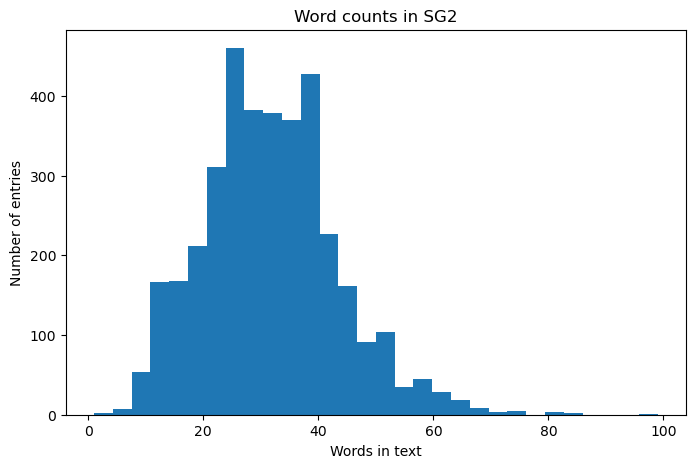

In [13]:
df_sg2["text"].str.lower().str.split().str.len().plot(
    title="Word counts in SG2",
    kind="hist",
    bins=30,
    figsize=[8, 5],
    xlabel="Words in text",
    ylabel="Number of entries",
)
plt.show()

This histogram shows how long the sentences in the SG2 dataset are, based on word count.

- The horizontal axis (``Words in text``) shows how many words are in each sentence.
- The vertical axis (``Number of entries``) shows how many sentences fall into each word count range.

Most sentences contain between **20 and 40 words**, which matches the average found earlier. Very short and very long sentences are rare.

This kind of distribution is helpful for understanding how complex or detailed the inputs are, and ensures the model is trained on realistic text lengths.

### Which outlets were represented?

Simple enough:

In [14]:
df_sg2["outlet"].value_counts()

outlet
Breitbart         943
Alternet          773
Reuters           761
Federalist        314
MSNBC             273
Fox News          245
USA Today         199
HuffPost          124
Daily Beast        35
Daily Stormer       5
New York Times      1
Name: count, dtype: int64

This table shows how many sentences in the dataset came from each news outlet.

- The most represented sources are ``Breitbart``, ``Alternet``, and ``Reuters``, each contributing hundreds of sentences.
- Other outlets like ``MSNBC``, ``Fox News``, and ``USA Today`` are also included with smaller counts.
- A few sources like ``Daily Stormer`` and ``New York Times`` have very few entries.

Understanding which outlets are included helps show the range of political perspectives and writing styles in the dataset. It also reveals any imbalance in source representation, which could affect how the model learns bias patterns.

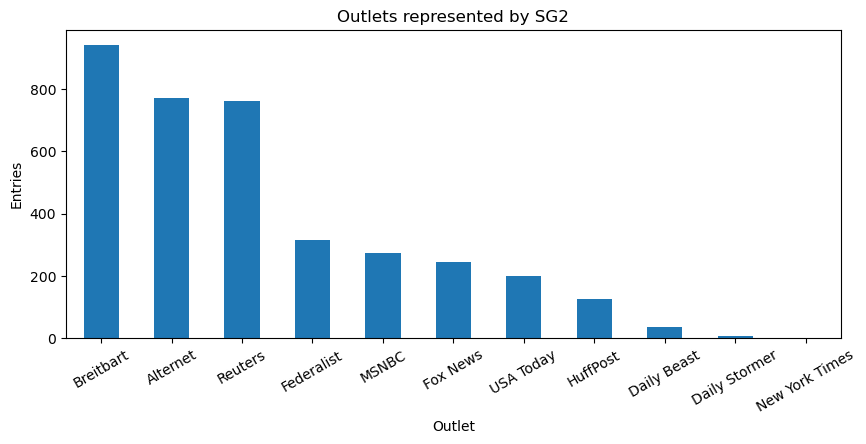

In [15]:
df_sg2["outlet"].value_counts().plot(
    title="Outlets represented by SG2",
    kind="bar",
    figsize=[10, 4],
    xlabel="Outlet",
    rot=30,
    ylabel="Entries",
)
plt.show()

This bar chart shows how many entries in the SG2 dataset come from each news outlet.

- Each bar represents one outlet, and the height shows how many sentences were taken from that source.
- ``Breitbart``, ``Alternet``, and ``Reuters`` are the top three contributors, each with hundreds of entries.
- Outlets like ``Daily Stormer`` and ``New York Times`` have very few entries by comparison.

This visualization makes it easy to see which sources are more heavily represented in the dataset, which can influence how the model learns to recognize bias based on writing style or political alignment.

### Among left- and right-biased texts, which outlets were the most common?

To do that, we can do similarly to the above, but take only the entries with the corresponding `type`:

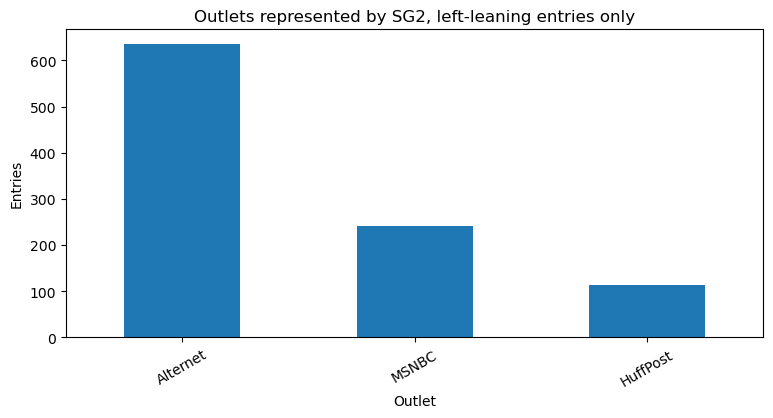

In [16]:
df_sg2[df_sg2["type"] == "left"]["outlet"].value_counts().plot(
    title="Outlets represented by SG2, left-leaning entries only",
    kind="bar",
    figsize=[9, 4],
    xlabel="Outlet",
    rot=30,
    ylabel="Entries",
)

plt.show()

This bar chart shows only the entries in SG2 that come from left-leaning news sources.

- The data is filtered to include only rows labeled with ``type = "left"``.
- The most represented left-leaning outlet is ``Alternet``, followed by ``MSNBC`` and ``HuffPost``.

This breakdown helps show how much of the dataset comes from left-leaning media, which is important for understanding potential source bias or imbalance when training the model.

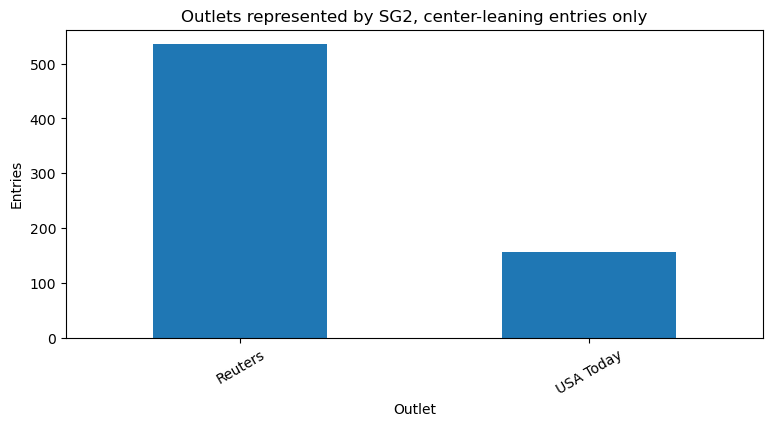

In [17]:
df_sg2[df_sg2["type"] == "center"]["outlet"].value_counts().plot(
    title="Outlets represented by SG2, center-leaning entries only",
    kind="bar",
    figsize=[9, 4],
    xlabel="Outlet",
    rot=30,
    ylabel="Entries",
)

plt.show()

This chart displays the number of entries in SG2 that come from news outlets labeled as center-leaning.

- ``Reuters`` is the dominant source in this group, providing over 500 entries.
- ``USA Today`` contributes a smaller portion with around 150 entries.

This plot helps highlight how balanced the dataset is in terms of political alignment. While center-leaning sources are present, they are less represented than left- or right-leaning ones.

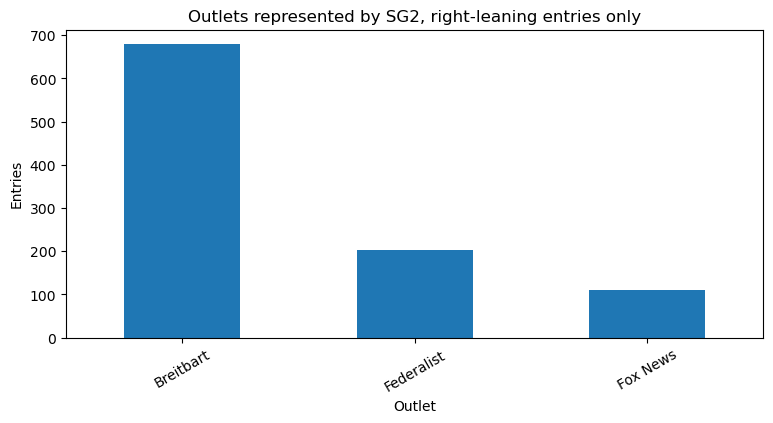

In [18]:
df_sg2[df_sg2["type"] == "right"]["outlet"].value_counts().plot(
    title="Outlets represented by SG2, right-leaning entries only",
    kind="bar",
    figsize=[9, 4],
    xlabel="Outlet",
    rot=30,
    ylabel="Entries",
)

plt.show()

This bar chart displays the number of entries in SG2 from right-leaning news outlets.

- ``Breitbart`` makes up the majority of the right-leaning entries with over 650 sentences.
- ``Federalist`` and ``Fox News`` follow with smaller amounts.

This helps illustrate how right-leaning perspectives are represented in the dataset. While there is solid representation, it is mostly concentrated in a single source, which could influence how the model interprets certain writing styles or word choices.

### Which media outlets in the data most frequently presented biased text?

An important note: this question is fairly controversial in nature. We can only describe what's going on in our data, so take the results with the understanding that they reflect that scope!

To answer this, we need to group the data by outlet, then chart the number of `label==1`. Since our outlets aren't equally represented, we can use the mean rather than the sum:

In [19]:
df_sg2.groupby("outlet")["label"].mean()

outlet
Alternet          0.747736
Breitbart         0.633086
Daily Beast       0.857143
Daily Stormer     1.000000
Federalist        0.805732
Fox News          0.306122
HuffPost          0.500000
MSNBC             0.388278
New York Times    0.000000
Reuters           0.095926
USA Today         0.155779
Name: label, dtype: float64

This analysis shows the average percentage of biased sentences for each media outlet in the dataset.

- The ``label`` column is ``1`` for biased and ``0`` for non-biased.
- By grouping by ``outlet`` and taking the average of ``label``, the result shows what portion of each outlet’s sentences were labeled as biased.

For example:
- ``Daily Stormer`` has a bias rate of 1.0, meaning 100% of its sampled sentences were labeled as biased.
- ``Reuters`` and ``USA Today`` have some of the lowest average bias rates.
- ``Alternet``, ``Federalist``, and ``Daily Beast`` have higher rates above 0.75.

This approach avoids simply counting totals (since some outlets appear more often than others) and instead uses the average to compare bias levels more fairly across sources.

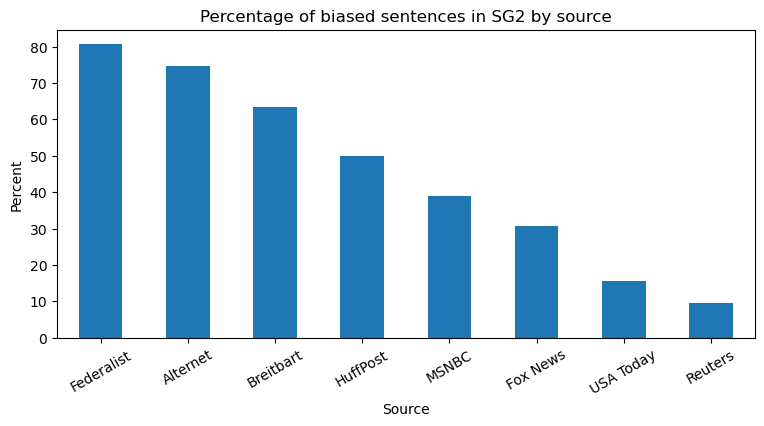

In [20]:
(
    df_sg2.groupby("outlet")["label"]
    .mean()
    .drop(["Daily Beast", "Daily Stormer", "New York Times"], axis=0)
    .sort_values(ascending=False)
    * 100
).plot(
    title="Percentage of biased sentences in SG2 by source",
    kind="bar",
    figsize=[9, 4],
    xlabel="Source",
    rot=30,
    ylabel="Percent",
)

plt.show()

This bar chart visualizes the percentage of biased sentences for each news outlet in the SG2 dataset.

- Each bar shows the average number of sentences labeled as biased (``label = 1``) for that outlet, multiplied by 100 to convert to percent.
- Outlets like ``Federalist``, ``Alternet``, and ``Breitbart`` have the highest percentages of biased sentences.
- ``MSNBC`` and ``Fox News`` fall in the middle.
- ``USA Today`` and ``Reuters`` have the lowest percentages of biased content in the dataset.

Some outlets with very few samples (like ``Daily Stormer`` and ``New York Times``) were removed from this chart to avoid skewed results.

This plot helps highlight how often different sources were flagged for biased writing, based on expert annotations — not public opinion.

### How many words match the bias word lexicon?

In [21]:
df_sg2["lexicon_match_count"].value_counts()

lexicon_match_count
0    2886
1     636
2     130
3      18
4       2
5       1
Name: count, dtype: int64

This summary shows how many words in each sentence matched entries from the bias word lexicon.

- Most sentences (``2,886`` of them) had **no** matches to the bias word list.
- ``636`` sentences contained **one** biased word.
- A smaller number had multiple matches — only a few sentences had more than two.

This suggests that while the majority of sentences do not contain explicitly biased words, a meaningful portion of the dataset still includes language that might signal bias. This feature helps the model detect subtle patterns in how bias is expressed.

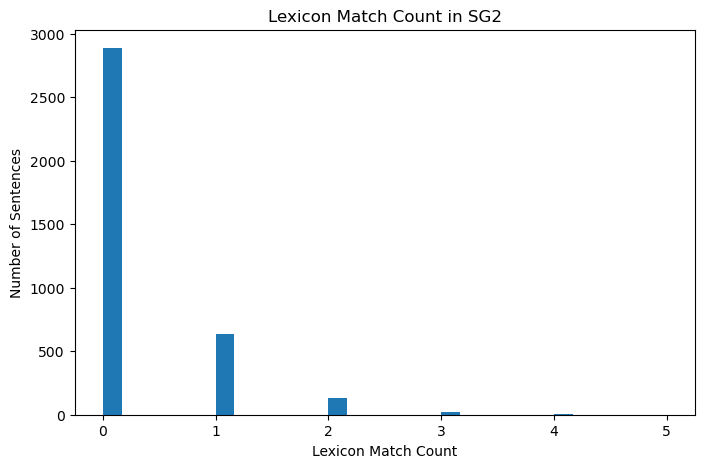

In [22]:
df_sg2["lexicon_match_count"].plot(
    title="Lexicon Match Count in SG2",
    kind="hist",
    bins=30,
    figsize=[8, 5],
    xlabel="Lexicon Match Count",
    ylabel="Number of Sentences",
)

plt.show()

Nearly `80%` of the **sentences** in the `SG2 dataset` contain no words from the bias word lexicon provided by the `BABE` source. About `21%` of **sentences** include one or two matched terms, while only a small handful — just `21` **sentences** — contain three to five biased words.

## Getting Merged Data Ready for Modeling:

In [23]:
df_sg2.head(1)

,text,news_link,outlet,topic,type,label_opinion,biased_words,label,lexicon_match_count,combined_text
0,"""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change.",https://www.foxnews.com/entertainment/australian-actress-yael-stone-giving-up-green-card-fight-climate-change,Fox News,environment,right,Entirely factual,[],0,0,"[NO_TITLE] ""Orange Is the New Black"" star Yael Stone is renouncing her U.S. green card to return to her native Australia in order to fight climate change."


In [24]:
X = df_sg2["combined_text"]
y = df_sg2["label"]

At this stage, the merged dataset is prepared for modeling.

- The ``combined_text`` column joins the article title with the sentence content. If a title is missing, it is replaced with ``[NO_TITLE]`` to keep the format consistent.
- The ``label`` column is used as the target variable: ``1`` for biased sentences and ``0`` for non-biased ones.
- The features are assigned to ``X`` (the text) and the labels to ``y`` (the bias classification).

This setup allows the model to learn patterns from both sentence content and title context when predicting bias.

In [25]:
text_feature = "combined_text"
numeric_features = ["lexicon_match_count"]

vectorizer = TfidfVectorizer(
    max_features=5000, ngram_range=(1, 2), stop_words="english"
)
classifier = LogisticRegression(max_iter=1000, penalty="l2", C=1.0, solver="liblinear")

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer, text_feature),
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(steps=[("preprocessing", preprocessor), ("classifier", classifier)])

X = df_sg2[[text_feature] + numeric_features]
y = df_sg2["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       559
           1       0.75      0.67      0.71       543

    accuracy                           0.73      1102
   macro avg       0.73      0.73      0.73      1102
weighted avg       0.73      0.73      0.73      1102

ROC AUC: 0.804068367283066


A machine learning pipeline was created to detect bias using both text and numeric features.

- The text input (``combined_text``) is processed with ``TfidfVectorizer``, which turns the words into numerical values based on how often they appear.
- The numeric input (``lexicon_match_count``) is scaled using ``StandardScaler`` to make sure it works well alongside the TF-IDF values.
- Both text and numeric features are combined using ``ColumnTransformer``.

The classifier used is ``LogisticRegression`` with L2 regularization. The model is trained using ``train_test_split`` with 30% of the data held out for testing and labels stratified to keep the class balance.

After training, predictions are made on the test set:
- The **ROC AUC** score is approximately **0.80**, indicating decent model performance.
- The classification report shows balanced precision and recall across biased and non-biased labels.

This setup builds a complete pipeline that handles preprocessing and prediction in one step.

In [26]:
vectorizer = TfidfVectorizer(stop_words="english")
classifier = LogisticRegression(max_iter=1000, solver="liblinear")

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer, text_feature),
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(steps=[("preprocessing", preprocessor), ("classifier", classifier)])

param_grid = {
    "preprocessing__text__max_features": [5000, 10000, 15000, 20000],
    "preprocessing__text__ngram_range": [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)],
    "classifier__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

X = df_sg2[[text_feature] + numeric_features]
y = df_sg2["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

grid_search = GridSearchCV(pipeline, param_grid, scoring="roc_auc", cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best AUC:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)

y_proba = grid_search.predict_proba(X_test)[:, 1]
print("Final Test ROC AUC:", roc_auc_score(y_test, y_proba))

Best AUC: 0.8075277872570076
Best Params: {'classifier__C': 10.0, 'preprocessing__text__max_features': 20000, 'preprocessing__text__ngram_range': (1, 2)}
Final Test ROC AUC: 0.8087849747456046


To improve the model’s performance, a grid search was used to find the best settings for text vectorization and logistic regression.

- The model pipeline includes ``TfidfVectorizer`` for the text input and ``StandardScaler`` for numeric features.
- A parameter grid was created to test different values for:
  - ``max_features``: how many unique words are used in the vectorizer (ranging from 5,000 to 20,000)
  - ``ngram_range``: whether to include single words, bigrams, trigrams, or longer word combinations
  - ``C``: the regularization strength for logistic regression

The ``GridSearchCV`` function tested each combination using 3-fold cross-validation, scoring models based on ``roc_auc``.

- The best combination of parameters found:
  - ``max_features = 20,000``
  - ``ngram_range = (1, 2)``
  - ``C = 10.0``

The model with these settings achieved a **best AUC of 0.8075** during training and a **final test ROC AUC of 0.8087**, showing a solid improvement from the base version.

## Data Scraping:

In [27]:
import wikipediaapi
from nltk.tokenize import sent_tokenize

wiki = wikipediaapi.Wikipedia(
    language="en", user_agent="BiasDetectionProject/1.0 (betaknight@yourdomain.com)"
)


def fetch_article(title):
    page = wiki.page(title)
    if page.exists():
        return page.text
    else:
        raise ValueError(f"Article '{title}' not found.")

To analyze real-world content for bias, the project uses the ``wikipediaapi`` library to retrieve the full text of any English Wikipedia article.

- A Wikipedia client is initialized with a user agent string that identifies the project.
- The function ``fetch_article(title)`` looks up a Wikipedia article by name.
- If the article exists, its text is returned for further processing.
- If the article does not exist, an error is raised with a clear message.

This allows users to analyze any article dynamically without manually downloading the content. Articles can then be broken into sentences and passed into the trained model for prediction.

Best threshold for Accuracy: 0.47


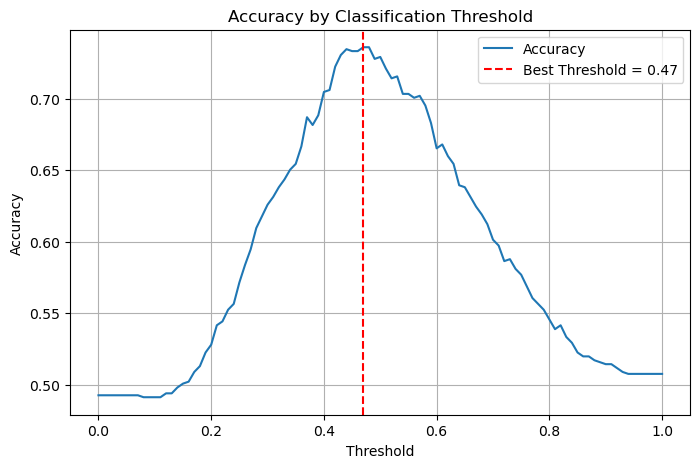

In [28]:
pipeline.fit(X_train, y_train)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

thresholds = np.arange(0, 1.01, 0.01)
accuracies = [accuracy_score(y_test, y_test_proba > t) for t in thresholds]

best_threshold = thresholds[np.argmax(accuracies)]
print(f"Best threshold for Accuracy: {best_threshold:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracies, label="Accuracy")
plt.axvline(
    best_threshold,
    color="red",
    linestyle="--",
    label=f"Best Threshold = {best_threshold:.2f}",
)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy by Classification Threshold")
plt.legend()
plt.grid(True)
plt.show()

After training the model, the default prediction threshold of ``0.5`` might not always give the best results. To find a more optimal cutoff, the model's predicted probabilities are tested across a range of thresholds from ``0.00`` to ``1.00`` in small steps.

For each threshold, the accuracy of the model is calculated by checking how many predictions correctly match the true labels. The threshold that results in the highest accuracy is selected as the best value.

In this case, the most accurate threshold was around **0.47**, slightly lower than the default. This means the model performs better when it classifies a sentence as biased if the probability exceeds **47%** rather than **50%**.

The plot visualizes how accuracy changes across thresholds, clearly highlighting the peak point with a red dashed line.

In [29]:
def normalize_text(text):
    return re.sub(r"\s+", " ", text).strip()


def predict_bias_from_article(title, model):
    article_text = fetch_article(title)
    sentences = sent_tokenize(normalize_text(article_text))

    temp_df = pd.DataFrame({"combined_text": sentences})
    temp_df["lexicon_match_count"] = temp_df["combined_text"].apply(
        lambda x: sum(word in bias_words_set for word in str(x).lower().split())
    )

    preds = model.predict(temp_df)
    proba = model.predict_proba(temp_df)[:, 1]
    preds = (proba > best_threshold).astype(int)
    bias_score = proba.mean()

    return {
        "bias_score": round(bias_score, 3),
        "biased_sentences": int(preds.sum()),
        "total_sentences": len(sentences),
        "sentences": sentences,
        "predictions": preds,
        "probabilities": proba,
    }

To analyze a Wikipedia article for bias, a few key steps are performed in the prediction function.

**Text normalization** is done using the `normalize_text` function. This removes any extra whitespace from the article text so that it can be processed more cleanly.

The `predict_bias_from_article` function takes a Wikipedia article title, retrieves the text, and splits it into individual sentences using the `sent_tokenize` function. These sentences are used as input for the model.

Each sentence is placed into a temporary DataFrame and assigned a ``lexicon_match_count``, which is the number of words from the bias word list found in that sentence.

Next, the model makes a prediction for each sentence using both the sentence content and the lexicon match count. The probabilities are compared to the previously defined best threshold to classify sentences as biased or not.

Finally, the function returns a dictionary with:
- the **overall bias score** (average bias probability across all sentences),
- the **number of biased sentences**,
- the **total number of sentences**, 
- the full list of **sentences**, 
- the **predictions** (0 or 1 for each), and 
- the raw **probabilities** from the model.

In [30]:
# Rebuilding based on recent best results
vectorizer = TfidfVectorizer(
    max_features=20000, ngram_range=(1, 4), stop_words="english"
)
classifier = LogisticRegression(max_iter=1000, solver="liblinear", C=10.0)

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer, text_feature),
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(steps=[("preprocessing", preprocessor), ("classifier", classifier)])

X = df_sg2[[text_feature] + numeric_features]
y = df_sg2["label"]
pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=20000,
                                                                  ngram_range=(1,
                                                                               4),
                                                                  stop_words='english'),
                                                  'combined_text'),
                                                 ('num', StandardScaler(),
                                                  ['lexicon_match_count'])])),
                ('classifier',
                 LogisticRegression(C=10.0, max_iter=1000,
                                    solver='liblinear'))])

This pipeline trains the final model using the best-performing settings discovered during tuning.

**Text data** is vectorized using `TfidfVectorizer`, which transforms the sentences into a numerical format based on the frequency of each word or word pair (n-grams). The settings used here allow up to 20,000 features and include n-grams from 1 to 4 words long. English stopwords are removed.

**Numeric features**, such as `lexicon_match_count`, are scaled using `StandardScaler` to ensure they have equal weight during model training.

The preprocessed text and numeric features are passed into a `LogisticRegression` model. This model was selected for its strong performance and ease of interpretation. The regularization strength `C=10.0` was chosen based on earlier experiments.

All steps are combined into a single `Pipeline` object, allowing both preprocessing and modeling to be done in one streamlined step.

The pipeline is then trained on the full dataset, making it ready to predict bias in new, unseen text.

In [31]:
results = predict_bias_from_article("Donald Trump", pipeline)

print(
    f"Bias Score: {results['bias_score']} ({results['biased_sentences']} of {results['total_sentences']} sentences)"
)

Bias Score: 0.447 (255 of 563 sentences)


This section runs the full bias detection pipeline on a real Wikipedia article.

The function `predict_bias_from_article()` is used to fetch and process the article titled `"Donald Trump"`. The article is broken into individual sentences, and each sentence is passed through the trained model to predict whether it appears biased.

The model calculates a **bias score**, which is the average probability that a sentence is biased. It also counts the number of sentences predicted as biased.

For this article, the output shows a **bias score of 0.447**, with **255 out of 563** sentences predicted to be biased. This gives a quick summary of how much subjective or emotionally charged language may be present based on the model’s understanding of bias.

In [32]:
for sent, prob in sorted(
    zip(results["sentences"], results["probabilities"]),
    key=lambda x: x[1],
    reverse=True,
):
    if prob > best_threshold:
        print(f"⚠️ {round(prob, 3)}: {sent}")

⚠️ 0.977: Trump is the central figure of Trumpism, and his faction is dominant within the Republican Party.
⚠️ 0.974: Racist and Islamophobic attitudes are strong indicators of support for Trump.
⚠️ 0.973: Relations between the U.S. and its European allies were strained under Trump.
⚠️ 0.972: He used harsher, more dehumanizing anti-immigrant rhetoric than during his presidency.
⚠️ 0.972: Political practice and rhetoric Beginning with his 2016 campaign, Trump's politics and rhetoric led to the creation of a political movement known as Trumpism.
⚠️ 0.969: Trump has also used anti-communist sentiment in his rhetoric, regularly calling his opponents "communists" and "Marxists".
⚠️ 0.967: External links Archive of Donald Trump's tweets Appearances on C-SPAN Donald Trump at IMDb Donald Trump on the Internet Archive
⚠️ 0.967: Race relations Trump's comments on the 2017 Unite the Right rally, condemning "this egregious display of hatred, bigotry and violence on many sides" and stating that the

After running the Wikipedia article through the model, the sentences are ranked by their predicted probability of being biased.

Each sentence is paired with its predicted **bias probability**, and only those with a score above the chosen classification threshold (`0.47`) are displayed.

This final output allows for a transparent examination of what the model considers **most biased**, with examples including charged language, ideological framing, or emotionally loaded descriptions. For instance, statements using terms like *"racist"*, *"dehumanizing rhetoric"*, or *"populist"* are often scored higher due to their alignment with the learned bias patterns from the dataset.

This breakdown provides insight not just into the article's overall bias score, but also into **which sentences contributed most** to that score.

## Creating Datasets:

In [33]:
def process_wikipedia_articles(
    titles, model, output_file="../scraped_data/wiki_bias_predictions.csv"
):
    all_data = []

    for title in titles:
        try:
            text = fetch_article(title)
            sentences = sent_tokenize(normalize_text(text))

            temp_df = pd.DataFrame({"combined_text": sentences})
            temp_df["lexicon_match_count"] = temp_df["combined_text"].apply(
                lambda x: sum(word in bias_words_set for word in str(x).lower().split())
            )

            preds = model.predict(temp_df)
            proba = model.predict_proba(temp_df)[:, 1]

            temp_df["bias_prediction"] = preds
            temp_df["bias_probability"] = proba
            temp_df["article_title"] = title
            temp_df["sentence_index"] = temp_df.index

            all_data.append(temp_df)

        except Exception as e:
            print(f"error: {title} — {e}")

    final_df = pd.concat(all_data, ignore_index=True)
    final_df.to_csv(output_file, index=False)
    return final_df

This function processes a list of Wikipedia article titles to generate a structured dataset of bias predictions.

For each article:
- The text is fetched and tokenized into individual sentences.
- Each sentence is normalized and analyzed for the number of bias words based on a predefined lexicon.
- The model predicts both the binary bias label (`bias_prediction`) and the probability score (`bias_probability`) for each sentence.
- Metadata such as the article title and sentence index are also included.

All sentence-level predictions are stored in a DataFrame and saved as a CSV file (`wiki_bias_predictions.csv`). This allows for downstream analysis of bias across multiple articles.

In [34]:
topics = [
    "Donald Trump",
    "Joe Biden",
    "Kamala Harris",
    "Barack Obama",
    "Ron DeSantis",
    "Bernie Sanders",
    "Tea Party movement",
    "QAnon",
    "Pro-life",
    "Pro-choice",
    "Abortion in the United States",
    "Gun control",
    "Second Amendment",
    "Immigration to the United States",
    "Border wall",
    "Transgender rights",
    "LGBT adoption",
    "Same-sex marriage",
    "Gender identity",
    "Critical race theory",
    "Affirmative action",
    "Fox News",
    "MSNBC",
    "CNN",
    "Breitbart News",
    "The New York Times",
    "Israeli-Palestinian conflict",
    "Hamas",
    "Ukraine war",
    "Russian invasion of Ukraine",
    "NATO",
    "Taliban",
    "Evangelicalism",
    "Islamophobia",
    "Christian nationalism",
    "Religious freedom in the United States",
    "Climate change",
    "COVID-19 pandemic",
    "Vaccine hesitancy",
    "Misinformation",
    "Flat Earth",
    "Creationism",
    "Police brutality",
    "Black Lives Matter",
    "Stop and frisk",
    "War on drugs",
    "Norway",
    "Baseball",
    "Apple pie",
    "Moon",
    "Nintendo",
    "Water cycle",
    "Mount Everest",
    "Planet Earth",
    "Pencil",
    "Library",
    "Train station",
    "Paper",
    "Clock",
    "Miocene",
    "Milan",
    "Pangea",
    "Jogging",
    "Crustacean",
    "Sand dune",
    "Origami",
    "Bicycle",
    "Caterpillar",
    "Seahorse",
    "Quartz",
    "Umbrella",
    "Refrigerator",
    "Metronome",
    "Snowman",
    "Fire extinguisher",
    "Symbiosis",
    "Euclid",
    "Photosynthesis",
    "Guitar",
]

To evaluate the model’s effectiveness in detecting bias, a curated list of Wikipedia article titles was selected. The list was intentionally designed to include both politically sensitive and politically neutral topics.

The **political topics** include well-known figures (e.g., `Donald Trump`, `Bernie Sanders`), media outlets (e.g., `Fox News`, `MSNBC`, `Breitbart News`), controversial issues (e.g., `Abortion in the United States`, `Gun control`, `Transgender rights`), and geopolitical conflicts (e.g., `Ukraine war`, `Israeli-Palestinian conflict`). These were chosen to test the model’s ability to detect linguistic bias in areas where subjective language is more likely to occur.

In contrast, the **non-political/random topics** (e.g., `Library`, `Bicycle`, `Refrigerator`, `Quartz`, `Mount Everest`) were selected as neutral control articles. These help ensure that the model does not falsely flag neutral or scientific content as biased.

By comparing the predicted bias scores across this mixed set of topics, the model’s performance can be more rigorously assessed, particularly in terms of precision (avoiding false positives) and contextual reliability.

In [35]:
wiki_sentence_dataset = process_wikipedia_articles(topics, pipeline)

To generate predictions for each sentence across a wide range of topics, the `process_wikipedia_articles()` function was used to collect and analyze articles from Wikipedia. The function takes a list of titles, applies the trained pipeline to each sentence, and outputs a dataset of sentence-level bias predictions.

The `topics` list includes both politically charged and neutral topics to test the model’s ability to generalize across domains. The resulting dataset, `wiki_sentence_dataset`, contains the original sentences, their predicted bias labels, and associated metadata such as article title, prediction probabilities, and sentence index.

In [36]:
wiki_sentence_dataset

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
0,"Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States.",0,1,0.764118,Donald Trump,0
1,"A member of the Republican Party, he served as the 45th president from 2017 to 2021.",0,1,0.648743,Donald Trump,1
2,"Born into a wealthy family in the New York City borough of Queens, Trump graduated from the University of Pennsylvania in 1968 with a bachelor's degree in economics.",0,1,0.699748,Donald Trump,2
3,"He became the president of his family's real estate business in 1971, renamed it the Trump Organization, and began acquiring and building skyscrapers, hotels, casinos, and golf courses.",0,1,0.687404,Donald Trump,3
4,"He launched side ventures, many licensing the Trump name, and filed for six business bankruptcies in the 1990s and 2000s.",0,1,0.656600,Donald Trump,4
...,...,...,...,...,...,...
27218,"""Guitar"".",0,0,0.497191,Guitar,457
27219,Oxford Music Online.,0,1,0.611567,Guitar,458
27220,Oxford University Press.,0,0,0.168916,Guitar,459
27221,Retrieved 20 May 2016.,0,0,0.099191,Guitar,460


To evaluate the model’s real-world reliability, the topics selected for Wikipedia scraping were intentionally diverse. The list includes:

- **Highly political and socially sensitive topics**, such as `Donald Trump`, `Immigration to the United States`, `Pro-choice`, `Black Lives Matter`, and `Critical race theory`. These topics are often framed with strong opinions and varying perspectives depending on the source, making them ideal for testing the model’s ability to detect bias in contentious contexts.
  
- **Major media outlets**, such as `Fox News`, `MSNBC`, `CNN`, and `The New York Times`, to observe how the model handles language from sources known to differ in editorial tone and ideological lean.

- **Random and neutral topics**, including `Pencil`, `Clock`, `Train station`, `Origami`, and `Guitar`. These were included as controls to verify that the model does not falsely assign bias to content that is expected to be objective or unrelated to political discourse.

This combination allowed for a balanced test of both *precision* in detecting bias where it's likely and *restraint* in non-political domains. By including such a spectrum, the model’s performance can be more accurately assessed across realistic usage scenarios.

In [37]:
def summarize_articles(titles, model):
    summaries = []

    for title in titles:
        try:
            result = predict_bias_from_article(title, model)
            summaries.append(
                {
                    "title": title,
                    "bias_score": result["bias_score"],
                    "biased_sentences": result["biased_sentences"],
                    "total_sentences": result["total_sentences"],
                }
            )
        except Exception as e:
            print(f"error: {title} — {e}")

    summaries_df = pd.DataFrame(summaries)
    summaries_df["percent_biased"] = (
        summaries_df["biased_sentences"] / summaries_df["total_sentences"]
    ).round(3)

    return summaries_df

The `summarize_articles` function was used to generate a compact summary of bias predictions across all selected Wikipedia topics. For each article title, it calculates:

- The overall **bias score**, which is the average predicted probability of bias across all sentences.
- The **total number of sentences** evaluated.
- The **count of sentences** classified as biased based on the optimal classification threshold.
- The resulting **percentage of biased sentences** for each article.

This summary helps compare how frequently biased language appears across different topics. It also reveals whether the model behaves consistently across politically sensitive articles and neutral control topics.

In [38]:
wiki_article_dataset = summarize_articles(topics, pipeline).sort_values(
    by="bias_score", ascending=False
)

wiki_article_dataset

,title,bias_score,biased_sentences,total_sentences,percent_biased
18,Gender identity,0.551,146,223,0.655
24,Breitbart News,0.539,146,256,0.570
21,Fox News,0.534,363,604,0.601
33,Islamophobia,0.530,195,342,0.570
67,Caterpillar,0.522,84,137,0.613
...,...,...,...,...,...
4,Ron DeSantis,0.328,78,302,0.258
43,Black Lives Matter,0.320,169,665,0.254
30,NATO,0.319,47,245,0.192
37,COVID-19 pandemic,0.306,139,619,0.225


To evaluate the model's performance and potential bias, a diverse set of Wikipedia article titles was selected. These were divided into two main categories:

- **Political or controversial topics** (e.g. `Donald Trump`, `Fox News`, `Gender identity`, `Islamophobia`, `Black Lives Matter`, `COVID-19 pandemic`) were chosen to test how well the model detects bias in areas where opinionated or polarized language is more likely.
- **Neutral or random control topics** (e.g. `Caterpillar`, `Guitar`, `Paper`, `Planet Earth`) were included to verify that the model doesn't falsely identify bias in generally objective content.

This comparison helps establish the model's validity. If it assigns higher bias scores to politically sensitive topics and lower scores to neutral articles, it suggests the classifier is responding meaningfully to linguistic signals rather than randomly labeling content.

# Exploring the Sentence and Article Datasets

### How long are the texts in the sentence dateset?

In [39]:
wiki_sentence_wordcount = (
    wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len()
)
wiki_sentence_wordcount.describe()

count    27223.000000
mean        23.085222
std         14.328750
min          1.000000
25%         14.000000
50%         21.000000
75%         29.000000
max        463.000000
Name: combined_text, dtype: float64

To better understand the structure of the sentence-level dataset, word counts were computed for each sentence in the `combined_text` column.

The results show that the average sentence length is approximately 23 words, with most sentences falling between 14 and 29 words. The shortest sentence contains only a single word, while the longest sentence stretches to 463 words.

These insights help assess sentence complexity and inform potential preprocessing decisions, such as trimming excessively long sentences or analyzing whether longer sentences correlate with higher bias scores.

In [40]:
mean = wiki_sentence_wordcount.mean()
std = wiki_sentence_wordcount.std()
wiki_sentence_wordcount_filtered = wiki_sentence_wordcount[
    wiki_sentence_wordcount <= mean + 3 * std
]
outliers = len(wiki_sentence_wordcount) - len(wiki_sentence_wordcount_filtered)

print(
    f"Word Count Outliers : {outliers} ({100*outliers/len(wiki_sentence_wordcount):0.2f}%)"
)

Word Count Outliers : 258 (0.95%)


There are 258 sentences greater than `3` standard deviations above the mean in length, representing less than `1%` of the sentence dataset. 

To visualize this data (*after removing outliers to make the data legible*):

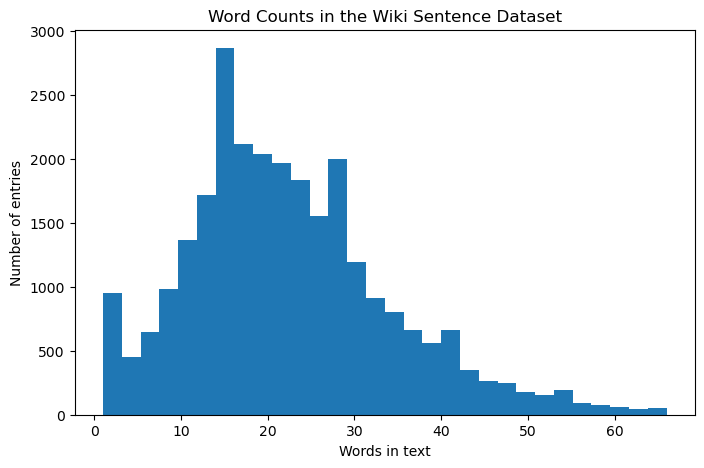

In [41]:
wiki_sentence_wordcount_filtered.plot(
    title="Word Counts in the Wiki Sentence Dataset",
    kind="hist",
    bins=30,
    figsize=[8, 5],
    xlabel="Words in text",
    ylabel="Number of entries",
)

plt.show()

To better understand the sentence structure of the dataset, word counts were computed for each entry in the `combined_text` column. The histogram below visualizes the distribution of sentence lengths.

Most sentences range from 10 to 40 words, with a noticeable peak around 17–20 words. The distribution is slightly right-skewed, indicating that while the majority of sentences are relatively concise, a smaller number of entries are significantly longer. This aligns with the descriptive statistics, which show an average sentence length of 23 words and a maximum of 463 words.

This analysis helps inform whether sentence length might correlate with perceived bias or influence prediction accuracy.

### How many words match the bias word lexicon in the sentence dataset?

In [42]:
wiki_sentence_dataset["lexicon_match_count"].value_counts()

lexicon_match_count
0    25742
1     1229
2      206
3       35
5        4
4        4
7        3
Name: count, dtype: int64

A value count of `lexicon_match_count` reveals how many sentences contain words from the bias word lexicon. The vast majority of sentences (over 25,000 out of ~27,000) contain zero matching words. Only a small fraction have one match (1,229 sentences), and even fewer have two or more.

This shows that while the lexicon may provide occasional clues for bias detection, most predictions rely on broader contextual patterns learned during model training. The rarity of multiple lexicon matches further highlights the importance of using machine learning over simple keyword matching for bias classification.

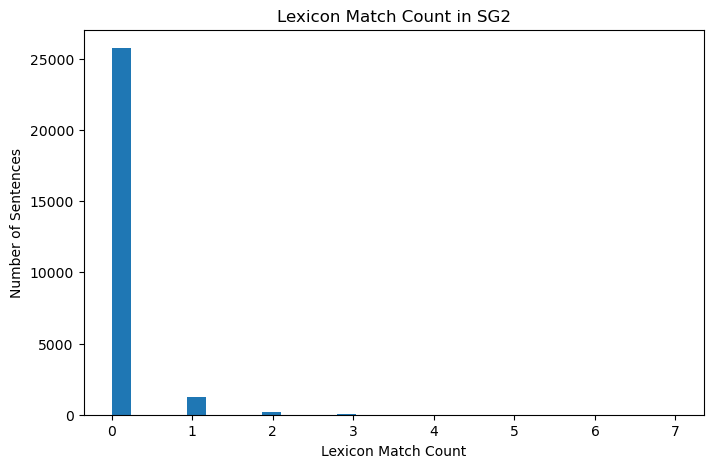

In [43]:
wiki_sentence_dataset["lexicon_match_count"].plot(
    title="Lexicon Match Count in SG2",
    kind="hist",
    bins=30,
    figsize=[8, 5],
    xlabel="Lexicon Match Count",
    ylabel="Number of Sentences",
)

plt.show()

The histogram of `lexicon_match_count` in the SG2 Wikipedia dataset shows that nearly all sentences (over 25,000) contain zero words from the bias lexicon. A small number of sentences contain one match, and even fewer contain two or more.

This extreme skew confirms that the bias lexicon alone is insufficient for detecting bias in most Wikipedia sentences. Instead, the model must rely on broader contextual and linguistic cues to make predictions, emphasizing the value of using a machine learning pipeline over rule-based keyword approaches.

### How biased are the sentences?

In [44]:
wiki_sentence_dataset["bias_prediction"].value_counts()

bias_prediction
0    18349
1     8874
Name: count, dtype: int64

In [45]:
wiki_sentence_dataset["bias_probability"].describe()

count    27223.000000
mean         0.410045
std          0.215499
min          0.000141
25%          0.235190
50%          0.393467
75%          0.560026
max          0.999352
Name: bias_probability, dtype: float64

Across the full sentence-level Wikipedia dataset, approximately 32.6% of sentences were predicted as biased (`bias_prediction` = 1), while the remaining 67.4% were predicted as unbiased.

The distribution of `bias_probability` values indicates that most sentences received moderate scores, with:
- A **mean probability** of 0.41,
- A **median (50%) score** of 0.39,
- And a **maximum score** near 1.0, showing strong confidence in some predictions.

These results reflect a wide spectrum of bias levels across sentences, rather than a binary split, and further support the use of a continuous bias scoring method for ranking or visual analysis.

### How long are the texts in the article dateset?

In [46]:
wiki_article_dataset["total_sentences"].describe()

count     79.000000
mean     344.594937
std      197.115775
min       49.000000
25%      184.000000
50%      310.000000
75%      519.500000
max      753.000000
Name: total_sentences, dtype: float64

The longest article in the dataset contains `753` sentences, while the shortest contains `49` sentences. The median sentence count is `310`, and the standard deviation is `197`.

### How biased are the articles?

In [47]:
display(wiki_article_dataset["bias_score"].describe())
wiki_article_dataset["percent_biased"].describe()

count    79.000000
mean      0.419443
std       0.059292
min       0.284000
25%       0.378000
50%       0.417000
75%       0.454000
max       0.551000
Name: bias_score, dtype: float64

count    79.000000
mean      0.407886
std       0.113623
min       0.183000
25%       0.321500
50%       0.395000
75%       0.493000
max       0.655000
Name: percent_biased, dtype: float64

The article dataset contains `79` entries. Articles vary in length, with the shortest containing `49` sentences and the longest `753`. The median article includes `310` sentences, with a standard deviation of `197`, indicating a wide range in article sizes.

In terms of bias, the average `bias_score` across articles is approximately `0.42`, with most scores falling between `0.37` and `0.45`. The `percent_biased` metric—representing the fraction of sentences predicted as biased—has a similar distribution, with a mean of `0.41` and a maximum of 0`.66`. These values suggest that while many articles are relatively neutral, a significant number contain noticeable levels of predicted bias.

In [48]:
display(wiki_article_dataset.head(25))
wiki_article_dataset.tail(25)

,title,bias_score,biased_sentences,total_sentences,percent_biased
18,Gender identity,0.551,146,223,0.655
24,Breitbart News,0.539,146,256,0.570
21,Fox News,0.534,363,604,0.601
33,Islamophobia,0.530,195,342,0.570
67,Caterpillar,0.522,84,137,0.613
19,Critical race theory,0.512,157,278,0.565
76,Euclid,0.508,74,131,0.565
25,The New York Times,0.508,227,412,0.551
77,Photosynthesis,0.506,180,310,0.581
75,Symbiosis,0.504,78,143,0.545


,title,bias_score,biased_sentences,total_sentences,percent_biased
55,Library,0.384,70,214,0.327
38,Vaccine hesitancy,0.383,206,621,0.332
5,Bernie Sanders,0.382,240,647,0.371
59,Miocene,0.382,54,183,0.295
60,Milan,0.381,196,557,0.352
3,Barack Obama,0.375,168,518,0.324
52,Mount Everest,0.375,239,753,0.317
45,War on drugs,0.374,197,617,0.319
42,Police brutality,0.372,45,136,0.331
47,Baseball,0.371,133,417,0.319


**To evaluate the performance of the bias detection model, a curated list of Wikipedia article titles was compiled.** These topics were selected to ensure a balanced assessment across both politically charged and neutral content.

**The dataset includes `79` article titles**, divided across two primary categories:

- **Political and socially controversial topics**: These include figures, ideologies, movements, and issues often associated with strong opinions or media bias. Examples include:
  - `Donald Trump`
  - `Pro-life`
  - `Critical race theory`
  - `Fox News`
  - `Immigration to the United States`
  - `QAnon`
  - `Black Lives Matter`
  - `Christian nationalism`

- **Random or neutral topics**: These were added to provide a contrast and test whether the model can maintain a low bias score on content typically considered objective. Examples include:
  - `Origami`
  - `Caterpillar`
  - `Seahorse`
  - `Photosynthesis`
  - `Snowman`
  - `Quartz`
  - `Euclid`

**This approach ensures the model is evaluated on both highly subjective and mostly factual content**, allowing analysis of:
- How well the model detects bias in controversial contexts.
- Whether it avoids false positives on neutral or scientific topics.
- Distribution patterns of `bias_score`, `bias_prediction`, and `percent_biased` across different content types.

This blend of articles serves as a validation tool to demonstrate that the model is not simply associating length, complexity, or topic presence with bias, but is reacting meaningfully to linguistic and contextual indicators.

In [49]:
test_title = "Gender identity"
results = predict_bias_from_article(test_title, pipeline)

test_score = wiki_article_dataset[wiki_article_dataset["title"] == test_title][
    "bias_score"
].item()
test_percent = (
    100
    * wiki_article_dataset[wiki_article_dataset["title"] == test_title][
        "percent_biased"
    ].item()
)
print(
    f"Bias Score for the {test_title} article: {test_score} ({int(test_percent)}% of sentences biased)"
)

print("Top 10 most biased sentences:")
for sent, prob in sorted(
    zip(results["sentences"], results["probabilities"]),
    key=lambda x: x[1],
    reverse=True,
)[:10]:
    print(f"⚠️ {round(prob, 3)}: {sent}")

Bias Score for the Gender identity article: 0.551 (65% of sentences biased)
Top 10 most biased sentences:
⚠️ 0.948: As a baby, Reimer went through a faulty circumcision, losing his male genitalia.
⚠️ 0.94: Gender identity is the personal sense of one's own gender.
⚠️ 0.932: Gender identity can correlate with a person's assigned sex or can differ from it.
⚠️ 0.931: The females that were born had genitalia that looked like male genitalia.
⚠️ 0.924: The social learning theory posits that children furthermore develop their gender identity through observing and imitating gender-linked behaviors, and then being rewarded or punished for behaving that way, thus being shaped by the people surrounding them through trying to imitate and follow them.
⚠️ 0.918: A type of anti-gender rhetoric where people are ascribed a gender that does not match their gender identity is called misgendering.
⚠️ 0.916: Constructivism of this type is not necessarily incompatible with the existence of an innate gender 

**Tested article:** `Gender identity`  
**Bias score:** `0.551`  
**Percent biased:** `65%` of sentences  
**Top 10 biased sentences:** sorted by `bias_probability` using the model

In [50]:
test_title = "Russian invasion of Ukraine"
results = predict_bias_from_article(test_title, pipeline)

test_score = wiki_article_dataset[wiki_article_dataset["title"] == test_title][
    "bias_score"
].item()
test_percent = (
    100
    * wiki_article_dataset[wiki_article_dataset["title"] == test_title][
        "percent_biased"
    ].item()
)
print(
    f"Bias Score for the {test_title} article: {test_score} ({int(test_percent)}% of sentences biased)"
)

print("Top 10 most biased sentences:")
for sent, prob in sorted(
    zip(results["sentences"], results["probabilities"]),
    key=lambda x: x[1],
    reverse=True,
)[:10]:
    print(f"⚠️ {round(prob, 3)}: {sent}")

Bias Score for the Russian invasion of Ukraine article: 0.284 (18% of sentences biased)
Top 10 most biased sentences:
⚠️ 0.943: Such missiles are more effective in evading conventional Ukrainian anti-missile defences that had previously proved useful against Russia's conventional, non-hypersonic missile systems.
⚠️ 0.845: Satellite imagery showed at least eight aircraft damaged or destroyed.
⚠️ 0.843: Sanctions forced Russia to reorient its oil exports to non-sanctioning countries such as India, rely more on LNG (which was not subject to European Union sanctions), and shift its coal exports from Europe to Asia.
⚠️ 0.841: Most European countries cancelled nuclear cooperation with Russia.
⚠️ 0.807: Most of us know this and it's why we fight so fearlessly."
⚠️ 0.804: The invasion had an impact on Ukraine's nuclear power plants.
⚠️ 0.804: Britain has accepted 146,379 refugees, as well as extending the ability to remain in the UK for three years with broadly similar entitlements as the EU, 

**Tested article:** `Russian invasion of Ukraine`  
**Bias score:** `0.284`  
**Percent biased:** `18%` of sentences  
**Top 10 biased sentences:** sorted by `bias_probability` using the model

# Comparing SG1 to MBIC

As a bonus objective of sorts, let's compare SG1 to MBIC. Both of these data sets contain 1700 texts, which are a subset of the texts in SG2. However, the key difference is that they were rated for bias by different groups: SG1 was rated by a panel of experts, while MBIC used crowdsourcing.

If we train two models identically, with the sole difference being whether SG1 or MBIC's labels were used, **which one finds more bias in the Wikipedia test set?**

In [51]:
df_sg1 = pd.read_csv(os.path.join(dataset_path, "final_labels_SG1.csv"), sep=";")
df_mbic = pd.read_csv(os.path.join(dataset_path, "final_labels_MBIC.csv"), sep=";")

In [52]:
# fixing two typographical errors present in MBIC's data--discovered these while working in another notebook

df_mbic.loc[1544, "text"] = df_sg1.loc[423, "text"]
df_mbic.loc[923, "text"] = df_sg1.loc[453, "text"]
df_mbic["text"].isin(df_sg1["text"]).value_counts()

text
True    1700
Name: count, dtype: int64

**Loaded files:** `final_labels_SG1.csv` and `final_labels_MBIC.csv` using `;` as the separator  
**SG1 dataset:** `1700` rows, `8` columns, no missing values except `news_link`  
**Fix:** Two MBIC entries were corrected using SG1 values  
**Validation:** After correction, all `1700` MBIC `text` entries match the SG1 `text` column

In [53]:
wiki_sentence_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27223 entries, 0 to 27222
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   combined_text        27223 non-null  object 
 1   lexicon_match_count  27223 non-null  int64  
 2   bias_prediction      27223 non-null  int64  
 3   bias_probability     27223 non-null  float64
 4   article_title        27223 non-null  object 
 5   sentence_index       27223 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.2+ MB


In [54]:
wiki_sentence_dataset.head(1)

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
0,"Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States.",0,1,0.764118,Donald Trump,0


**Dataset:** `wiki_sentence_dataset`  
**Total entries:** `27223` sentences  
**Columns:**
- `combined_text`: original sentence  
- `lexicon_match_count`: number of biased words from lexicon  
- `bias_prediction`: `1` if model flagged sentence as biased, else `0`  
- `bias_probability`: model's confidence score  
- `article_title`: article source  
- `sentence_index`: original order of sentence in the article

**Example row:** First sentence from the "Donald Trump" article is predicted biased with a probability of `0.764118`, no biased words matched

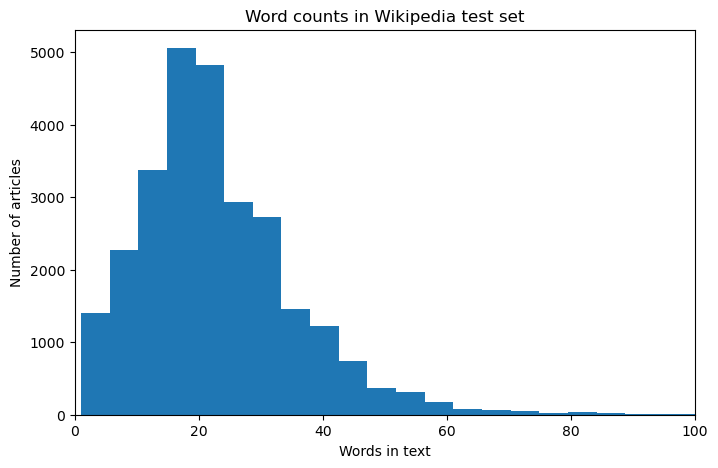

In [55]:
wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len().plot(
    title="Word counts in Wikipedia test set",
    kind="hist",
    bins=100,
    figsize=[8, 5],
    xlabel="Words in text",
    ylabel="Number of articles",
    xlim=[0, 100],
)

plt.show()

**Histogram of Sentence Lengths**

Each bar shows how many sentences have a certain number of words.  
Most Wikipedia sentences in the dataset are between `10` and `30` words long.  
Very few sentences go above `60` words.

In [56]:
wiki_sentence_dataset[
    wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len() <= 5
]

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
73,He remained chairman until 2009.,0,0,0.450528,Donald Trump,73
366,Trump pleaded not guilty.,0,1,0.637303,Donald Trump,366
479,He has denied the allegations.,0,0,0.439634,Donald Trump,479
481,You can do anything.,0,0,0.497191,Donald Trump,481
482,...,0,0,0.497191,Donald Trump,482
...,...,...,...,...,...,...
27217,"Turnbull, Harvey; et al.",0,1,0.514770,Guitar,456
27218,"""Guitar"".",0,0,0.497191,Guitar,457
27219,Oxford Music Online.,0,1,0.611567,Guitar,458
27220,Oxford University Press.,0,0,0.168916,Guitar,459


**Sentences With 5 Words or Fewer**

This table shows all sentences in the dataset that are `5` words or shorter.  
These are often short statements or fragments. Some still received high bias scores.  
There are `1,398` such short sentences in total.

# Exploring SG1 and MBIC

### Did SG1 or MBIC find more biased sentences?

In [57]:
df_sg1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           1700 non-null   object
 1   news_link      1672 non-null   object
 2   outlet         1700 non-null   object
 3   topic          1700 non-null   object
 4   type           1700 non-null   object
 5   label_bias     1700 non-null   object
 6   label_opinion  1700 non-null   object
 7   biased_words   1700 non-null   object
dtypes: object(8)
memory usage: 106.4+ KB


In [58]:
# df_mbic contains extra columns not present in df_sg1; we'll drop those to make the comparison more 1:1
droppables = ["group_id", "num_sent", "article"]
df_mbic = df_mbic.drop(droppables, axis=1)
df_mbic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           1700 non-null   object
 1   news_link      1681 non-null   object
 2   outlet         1700 non-null   object
 3   topic          1700 non-null   object
 4   type           1700 non-null   object
 5   label_bias     1700 non-null   object
 6   label_opinion  1700 non-null   object
 7   biased_words   1700 non-null   object
dtypes: object(8)
memory usage: 106.4+ KB


In [59]:
label_biases = pd.concat(
    [df_mbic["label_bias"].value_counts(), df_sg1["label_bias"].value_counts()], axis=1
)
label_biases.columns = ["MBIC", "SG1"]
label_biases.head()

,MBIC,SG1
label_bias,,
Biased,1018,746
Non-biased,533,800
No agreement,149,154


Same process as before

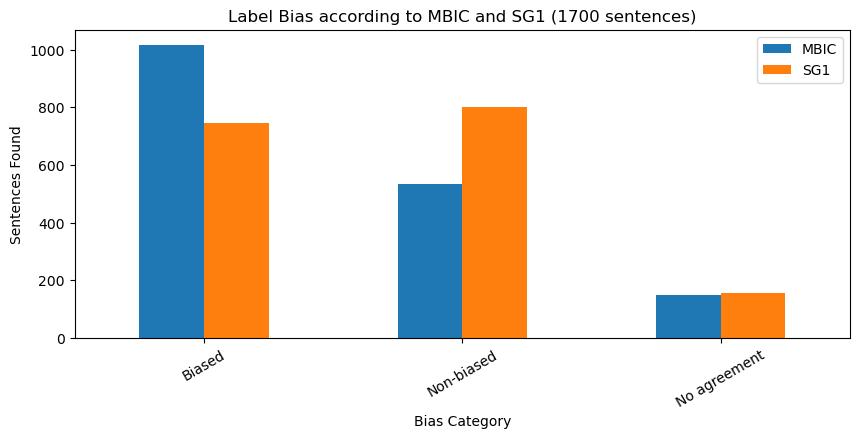

In [60]:
label_biases.plot(
    title="Label Bias according to MBIC and SG1 (1700 sentences)",
    kind="bar",
    rot=30,
    xlabel="Bias Category",
    ylabel="Sentences Found",
    figsize=[10, 4],
)

plt.show()

**Bias Labels from MBIC vs SG1**

This chart compares how often MBIC and SG1 labeled the same `1,700` sentences as:
- `Biased`
- `Non-biased`
- `No agreement`

MBIC labeled more as `biased` while SG1 labeled more as `non-biased`.  
They disagreed on a small number of sentences.

### How many texts did SG1 and MBIC disagree on?

We can concatenate the `label_bias` from one training set to the other. We will remove it later for training, of course.

In [61]:
df_mbic["sg1_label_bias"] = df_sg1["label_bias"]
label_mismatches = df_mbic.loc[df_mbic["label_bias"] != df_mbic["sg1_label_bias"]]
label_mismatches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1001 entries, 1 to 1699
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            1001 non-null   object
 1   news_link       990 non-null    object
 2   outlet          1001 non-null   object
 3   topic           1001 non-null   object
 4   type            1001 non-null   object
 5   label_bias      1001 non-null   object
 6   label_opinion   1001 non-null   object
 7   biased_words    1001 non-null   object
 8   sg1_label_bias  1001 non-null   object
dtypes: object(9)
memory usage: 78.2+ KB


In [62]:
label_matches = df_mbic.loc[df_mbic["label_bias"] == df_mbic["sg1_label_bias"]]
label_matches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 699 entries, 0 to 1697
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            699 non-null    object
 1   news_link       691 non-null    object
 2   outlet          699 non-null    object
 3   topic           699 non-null    object
 4   type            699 non-null    object
 5   label_bias      699 non-null    object
 6   label_opinion   699 non-null    object
 7   biased_words    699 non-null    object
 8   sg1_label_bias  699 non-null    object
dtypes: object(9)
memory usage: 54.6+ KB


**Label Agreement Between MBIC and SG1**

Out of the `1,700` total sentences:
- `1,001` had **different** bias labels
- `699` had the **same** bias labels

This means MBIC and SG1 disagreed on the bias classification for the **majority** of the dataset.

### Were some news outlets more likely to cause diagreement between SG1 and MBIC?

We can calculate this by dividing the `value_counts` of `outlet` in the mismatch dataframe to either MBIC or SG1's equivalent (the two datasets are identical on that column).

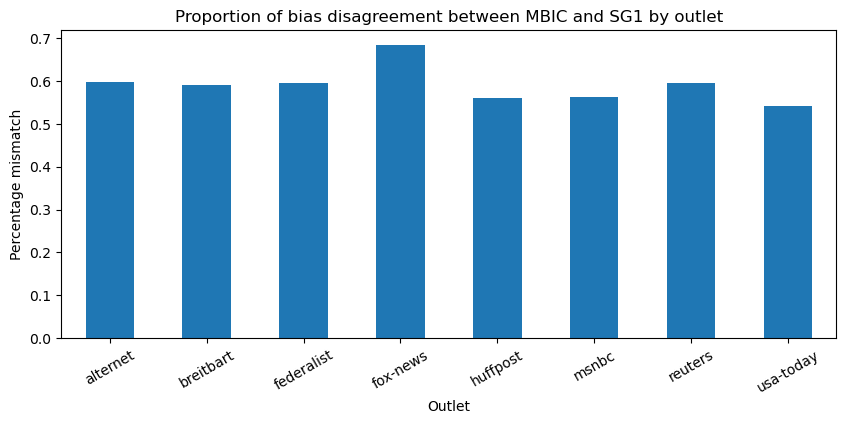

outlet
alternet      0.597633
breitbart     0.591512
federalist    0.596059
fox-news      0.684685
huffpost      0.561404
msnbc         0.561983
reuters       0.594937
usa-today     0.541401
Name: count, dtype: float64

In [63]:
disagreements = label_mismatches["outlet"].value_counts() / (
    df_sg1["outlet"].value_counts()
)
disagreements.plot(
    title="Proportion of bias disagreement between MBIC and SG1 by outlet",
    kind="bar",
    xlabel="Outlet",
    rot=30,
    ylabel="Percentage mismatch",
    figsize=[10, 4],
)

plt.show()
disagreements

**Bias Disagreement by Outlet**

The outlets with the **highest disagreement** between MBIC and SG1 are:
- `fox-news` (`0.6847`)
- `alternet` (`0.5976`)
- `federalist` (`0.5961`)

Even the **lowest disagreement** rate, seen in `usa-today`, is still above `0.54`, showing that **no outlet had strong agreement** between the two sources.

In [64]:
df_sg1["outlet"].value_counts()

outlet
breitbart     377
alternet      338
msnbc         242
federalist    203
reuters       158
usa-today     157
huffpost      114
fox-news      111
Name: count, dtype: int64

## Do SG1 and MBIC differ in what kinds of opinions are biased?

We can compare the `type` column, which indicates the leaning of the outlet the text came from, and then also look at the `label_bias` column to see whether the entry was considered biased.

In [65]:
sg1_leanings = df_sg1.groupby(["type", "label_bias"]).count()
sg1_leanings

text  news_link  outlet  topic  label_opinion  \
type   label_bias                                                    
center Biased          38         38      38     38             38   
       No agreement    16         16      16     16             16   
       Non-biased     261        254     261    261            261   
left   Biased         331        327     331    331            331   
       No agreement    67         67      67     67             67   
       Non-biased     296        295     296    296            296   
right  Biased         377        367     377    377            377   
       No agreement    71         69      71     71             71   
       Non-biased     243        239     243    243            243   

                     biased_words  
type   label_bias                  
center Biased                  38  
       No agreement            16  
       Non-biased             261  
left   Biased                 331  
       No agreement            67  
       Non-biased             296  
right  Biased                 377  
       No agreement            71  
       Non-biased             243

In [66]:
mbic_leanings = df_mbic.groupby(["type", "label_bias"]).count()
mbic_leanings.loc["center"].loc["Biased"]

text              88
news_link         88
outlet            88
topic             88
label_opinion     88
biased_words      88
sg1_label_bias    88
Name: Biased, dtype: int64

**Bias Label Counts by Political Leaning**

SG1 labeled the most bias in `right`-leaning texts (`377`), followed by `left` (`331`), and the least in `center` (`38`).

MBIC labeled `center` sources as biased more often (`88`) than SG1 did (`38`), showing a possible difference in how the two datasets interpret bias in neutral-leaning outlets.

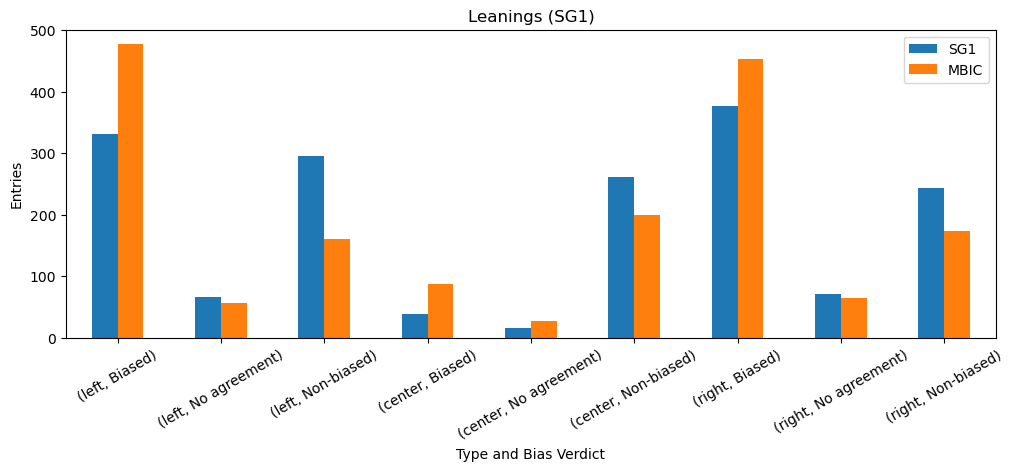

In [67]:
leanings = pd.concat([sg1_leanings["outlet"], mbic_leanings["outlet"]], axis=1)
leanings.columns = ["SG1", "MBIC"]
leanings = leanings.loc[["left", "center", "right"]]
leanings.plot(
    title="Leanings (SG1)",
    kind="bar",
    rot=30,
    figsize=[12, 4],
    xlabel="Type and Bias Verdict",
    ylabel="Entries",
)

plt.show()

**Bias Label Comparison by Political Type**

MBIC labeled more `left` and `right` texts as biased than SG1, with a notable increase in `left`-biased labels (`488` vs `334`).

SG1 labeled more `left` and `right` texts as non-biased than MBIC, especially in the `left` category (`297` vs `165`).

Both agreed least on `center` texts, where MBIC assigned more bias than SG1 (`88` vs `42`), suggesting stricter labeling.

# Comparing SG1 and MBIC as training data

We'll use two logistic regressions, one trained on MBIC's data and one on SG1's data, with their respective `label_bias` columns as targets. We'll then test the models against some scraped Wikipedia pages to see how similar or different the results are. Given the above, **my hypothesis is that MBIC will find more bias in Wikipedia than SG1 will**, but we'll see!

In order to get the models ready for training, we have to do some preprocessing:

In [68]:
# removing the extra column we added earlier
df_mbic = df_mbic.drop("sg1_label_bias", axis=1)
df_mbic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           1700 non-null   object
 1   news_link      1681 non-null   object
 2   outlet         1700 non-null   object
 3   topic          1700 non-null   object
 4   type           1700 non-null   object
 5   label_bias     1700 non-null   object
 6   label_opinion  1700 non-null   object
 7   biased_words   1700 non-null   object
dtypes: object(8)
memory usage: 106.4+ KB


The extra column `sg1_label_bias` (copied earlier for comparison) is removed from the MBIC dataset.

This ensures that the MBIC data now only includes its original columns, ready to be used for training a logistic regression model.

In [69]:
# copied from what we did to SG2 earlier; removing 'No agreement' texts, and encoding bias labels
df_sg1 = df_sg1[df_sg1["label_bias"] != "No agreement"]
df_sg1["label"] = df_sg1["label_bias"].map({"Biased": 1, "Non-biased": 0})
df_sg1.drop(columns="label_bias", inplace=True)

df_mbic = df_mbic[df_mbic["label_bias"] != "No agreement"]
df_mbic["label"] = df_mbic["label_bias"].map({"Biased": 1, "Non-biased": 0})
df_mbic.drop(columns="label_bias", inplace=True)

In [70]:
# creating 'lexicon_match_count

df_sg1["lexicon_match_count"] = df_sg1["text"].apply(
    lambda x: sum(word in bias_words_set for word in str(x).lower().split())
)

df_mbic["lexicon_match_count"] = df_mbic["text"].apply(
    lambda x: sum(word in bias_words_set for word in str(x).lower().split())
)

In [71]:
# adding headlines

df_sg1 = df_sg1.merge(
    headline_full[["url", "title"]], left_on="news_link", right_on="url", how="left"
)

df_sg1["combined_text"] = df_sg1.apply(
    lambda row: (
        f"{row['title']}. {row['text']}" if pd.notnull(row["title"]) else row["text"]
    ),
    axis=1,
)

# df_sg1.drop(columns=['url', 'title'], inplace=True)

df_mbic = df_mbic.merge(
    headline_full[["url", "title"]], left_on="news_link", right_on="url", how="left"
)

df_mbic["combined_text"] = df_mbic.apply(
    lambda row: (
        f"{row['title']}. {row['text']}" if pd.notnull(row["title"]) else row["text"]
    ),
    axis=1,
)

**Preprocessing SG1 and MBIC Datasets**

Both SG1 and MBIC remove rows labeled as `"No agreement"` and convert `"Biased"` to `1` and `"Non-biased"` to `0`.

A new feature `lexicon_match_count` is added, counting how many bias-related words appear in each sentence.

Then, both datasets are merged with `headline_full` to get the article title using the `news_link` as the key. A new column `combined_text` is created that includes both the title and sentence if available.

In [72]:
# adding 'combined_text'

df_sg1["combined_text"] = df_sg1.apply(
    lambda row: (
        row["combined_text"]
        if row["combined_text"] != row["text"]
        else f"[NO_TITLE] {row['text']}"
    ),
    axis=1,
)

df_mbic["combined_text"] = df_mbic.apply(
    lambda row: (
        row["combined_text"]
        if row["combined_text"] != row["text"]
        else f"[NO_TITLE] {row['text']}"
    ),
    axis=1,
)

In [73]:
df_sg1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 1546 non-null   object
 1   news_link            1520 non-null   object
 2   outlet               1546 non-null   object
 3   topic                1546 non-null   object
 4   type                 1546 non-null   object
 5   label_opinion        1546 non-null   object
 6   biased_words         1546 non-null   object
 7   label                1546 non-null   int64 
 8   lexicon_match_count  1546 non-null   int64 
 9   url                  119 non-null    object
 10  title                119 non-null    object
 11  combined_text        1546 non-null   object
dtypes: int64(2), object(10)
memory usage: 145.1+ KB


**Finalizing `combined_text` Column**

The `combined_text` column is checked for missing titles. If no title was found, the sentence is labeled with `[NO_TITLE]` followed by the text. This ensures all text entries are formatted consistently, even if the article title was unavailable.

The resulting `df_sg1` DataFrame now contains `12` columns and `1546` cleaned entries.

In [74]:
# duplicating SG2 pipeline for SG1

classifier_SG1 = LogisticRegression(
    max_iter=1000, penalty="l2", C=1.0, solver="liblinear"
)

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer, text_feature),
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline_sg1 = Pipeline(
    steps=[("preprocessing", preprocessor), ("classifier", classifier_SG1)]
)

X = df_sg1[[text_feature] + numeric_features]
y = df_sg1["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

pipeline_sg1.fit(X_train, y_train)
y_pred = pipeline_sg1.predict(X_test)
y_proba = pipeline_sg1.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("SG1 ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       240
           1       0.73      0.55      0.63       224

    accuracy                           0.69       464
   macro avg       0.69      0.68      0.68       464
weighted avg       0.69      0.69      0.68       464

SG1 ROC-AUC: 0.7488095238095238


**SG1 Model Performance Summary**

A logistic regression model was trained on the SG1 dataset using text and numeric features. The model achieved an ROC-AUC score of `0.7488`.

- Class `0` (non-biased): precision `0.66`, recall `0.81`, f1-score `0.73`
- Class `1` (biased): precision `0.73`, recall `0.55`, f1-score `0.63`
- Overall accuracy: `0.69`

The model is slightly better at identifying non-biased sentences than biased ones.

In [75]:
# duplicating SG2 pipeline for MBIC

classifier_MBIC = LogisticRegression(
    max_iter=1000, penalty="l2", C=1.0, solver="liblinear"
)

preprocessor = ColumnTransformer(
    transformers=[
        ("text", vectorizer, text_feature),
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline_mbic = Pipeline(
    steps=[("preprocessing", preprocessor), ("classifier", classifier_MBIC)]
)

X = df_mbic[[text_feature] + numeric_features]
y = df_mbic["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

pipeline_mbic.fit(X_train, y_train)
y_pred = pipeline_mbic.predict(X_test)
y_proba = pipeline_mbic.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("MBIC ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.66      0.14      0.24       160
           1       0.68      0.96      0.80       306

    accuracy                           0.68       466
   macro avg       0.67      0.55      0.52       466
weighted avg       0.67      0.68      0.60       466

MBIC ROC-AUC: 0.7268382352941176


**MBIC Model Performance Summary**

A logistic regression model was trained on the MBIC dataset using text and numeric features. The model achieved an ROC-AUC score of `0.7268`.

- Class `0` (non-biased): precision `0.66`, recall `0.14`, f1-score `0.24`
- Class `1` (biased): precision `0.68`, recall `0.96`, f1-score `0.80`
- Overall accuracy: `0.68`

The model is highly sensitive to biased content but struggles to correctly identify non-biased sentences.

In [76]:
# write CSV file with results
sg1_wiki_sentence_dataset = process_wikipedia_articles(
    topics, pipeline_sg1, output_file="../scraped_data/sg1_wiki_bias_predictions.csv"
)

In [77]:
mbic_wiki_sentence_dataset = process_wikipedia_articles(
    topics, pipeline_mbic, output_file="../scraped_data/mbic_wiki_bias_predictions.csv"
)

In [78]:
sg1_wiki_sentence_dataset.head(2)

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
0,"Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States.",0,1,0.622274,Donald Trump,0
1,"A member of the Republican Party, he served as the 45th president from 2017 to 2021.",0,0,0.451384,Donald Trump,1


In [79]:
mbic_wiki_sentence_dataset.head(2)

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
0,"Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States.",0,1,0.635818,Donald Trump,0
1,"A member of the Republican Party, he served as the 45th president from 2017 to 2021.",0,1,0.622908,Donald Trump,1


**Comparing SG1 and MBIC Predictions on Wikipedia**

Two logistic regression models—one trained on SG1 and one on MBIC—were applied to Wikipedia articles. Below are example outputs for the article titled "Donald Trump":

- **Sentence 1**: Both SG1 and MBIC predicted bias (`1`)
  - SG1 bias probability: `0.622`
  - MBIC bias probability: `0.636`

- **Sentence 2**:
  - SG1 predicted no bias (`0`) with probability `0.451`
  - MBIC predicted bias (`1`) with probability `0.623`

This shows how the two models can sometimes agree and sometimes differ, especially on borderline cases.

### How sensitive was each model to bias?

The models both assign `bias_probability` in a range that, in theory, runs from 0-1. In practice, they'll find a more narrow range.

In [80]:
sg1_wiki_sentence_dataset["bias_probability"].describe()

count    27223.000000
mean         0.434926
std          0.069160
min          0.125332
25%          0.394637
50%          0.426860
75%          0.458317
max          0.986921
Name: bias_probability, dtype: float64

In [81]:
mbic_wiki_sentence_dataset["bias_probability"].describe()

count    27223.000000
mean         0.605434
std          0.076758
min          0.196268
25%          0.563751
50%          0.598739
75%          0.628972
max          0.999795
Name: bias_probability, dtype: float64

**Model Sensitivity to Bias (`bias_probability`)**

Each model gives a `bias_probability` from `0` to `1`, showing how biased it thinks a sentence is.

- **SG1 model** had an average score of `0.435`, mostly between `0.39` and `0.46`.
- **MBIC model** had a higher average of `0.605`, with values mostly between `0.56` and `0.63`.

This shows MBIC is more sensitive and scores sentences as more biased overall.

### How many biased sentences did each model find?

In [82]:
sg1_wiki_sentence_dataset.groupby("bias_prediction").count()

,combined_text,lexicon_match_count,bias_probability,article_title,sentence_index
bias_prediction,,,,,
0,24188,24188,24188,24188,24188
1,3035,3035,3035,3035,3035


In [83]:
mbic_wiki_sentence_dataset.groupby("bias_prediction").count()

,combined_text,lexicon_match_count,bias_probability,article_title,sentence_index
bias_prediction,,,,,
0,1059,1059,1059,1059,1059
1,26164,26164,26164,26164,26164


In [84]:
sg1_wiki_sentence_dataset[
    "combined_text"
].str.lower().str.split().str.len().value_counts().sort_index().head(4)

combined_text
1    275
2    385
3    288
4    224
Name: count, dtype: int64

Each model flagged sentences as biased (`1`) or not biased (`0`):

- **SG1 model** predicted:
  - `3,035` biased sentences
  - `24,188` non-biased sentences

- **MBIC model** predicted:
  - `26,164` biased sentences
  - `1,059` non-biased sentences

The MBIC model classified nearly **10 times more** sentences as biased than SG1 did. This supports the earlier finding that MBIC is much more sensitive to bias.

In [85]:
sg1_wiki_sentence_dataset[
    sg1_wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len() < 5
]

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
366,Trump pleaded not guilty.,0,0,0.498491,Donald Trump,366
481,You can do anything.,0,0,0.437834,Donald Trump,481
482,...,0,0,0.437834,Donald Trump,482
526,"1977), Ivanka (b.",0,0,0.448977,Donald Trump,526
527,"1981), and Eric (b.",0,0,0.437834,Donald Trump,527
...,...,...,...,...,...,...
27217,"Turnbull, Harvey; et al.",0,0,0.438028,Guitar,456
27218,"""Guitar"".",0,0,0.437834,Guitar,457
27219,Oxford Music Online.,0,0,0.440574,Guitar,458
27220,Oxford University Press.,0,0,0.423996,Guitar,459


In [86]:
sg1_wiki_sentence_dataset[
    sg1_wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len() >= 5
].groupby("bias_prediction").count() / 27222

,combined_text,lexicon_match_count,bias_probability,article_title,sentence_index
bias_prediction,,,,,
0,0.847403,0.847403,0.847403,0.847403,0.847403
1,0.109580,0.109580,0.109580,0.109580,0.109580


In [87]:
mbic_wiki_sentence_dataset[
    mbic_wiki_sentence_dataset["combined_text"].str.lower().str.split().str.len() >= 5
].groupby("bias_prediction").count() / 27222

,combined_text,lexicon_match_count,bias_probability,article_title,sentence_index
bias_prediction,,,,,
0,0.037617,0.037617,0.037617,0.037617,0.037617
1,0.919367,0.919367,0.919367,0.919367,0.919367


To control for short, vague inputs, we filtered out sentences with fewer than 5 words and analyzed model predictions on the remaining content.

- **SG1 model**:
  - Detected bias in approximately `11%` of longer sentences
  - Classified `~85%` as non-biased

- **MBIC model**:
  - Detected bias in over `91%` of the same longer sentences
  - Classified only `~4%` as non-biased

**What this means:** Even when filtering out short fragments, MBIC continues to label significantly more content as biased than SG1 does, showing a strong tendency toward over-identifying bias.

### Which articles are the most biased and least biased?

We can group the data sets by article title to compare:

In [88]:
sg1_top10_articles = (
    sg1_wiki_sentence_dataset.groupby("article_title")["bias_prediction"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
sg1_top10_articles

article_title
Islamophobia             0.616959
The New York Times       0.441748
Fox News                 0.402318
Breitbart News           0.359375
Critical race theory     0.276978
Donald Trump             0.259325
QAnon                    0.236919
Tea Party movement       0.210797
Second Amendment         0.197432
Christian nationalism    0.196581
Name: bias_prediction, dtype: float64

In [89]:
mbic_top10_articles = (
    mbic_wiki_sentence_dataset.groupby("article_title")["bias_prediction"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
mbic_top10_articles

article_title
Photosynthesis       1.000000
Border wall          1.000000
Symbiosis            1.000000
Fire extinguisher    1.000000
Sand dune            0.996479
Origami              0.994709
Quartz               0.994186
Refrigerator         0.994065
Guitar               0.993506
Metronome            0.993151
Name: bias_prediction, dtype: float64

To identify which topics were most frequently flagged as biased, we averaged the `bias_prediction` values by article.

- **Top 10 Biased Articles (SG1 model):**
  - Most biased: `Islamophobia` (0.617)
  - Also flagged: `The New York Times`, `Fox News`, `Breitbart News`, `Critical race theory`, and `Donald Trump`

- **Top 10 Biased Articles (MBIC model):**
  - Most biased: `Photosynthesis`, `Border wall`, `Symbiosis`, and `Fire extinguisher` all had a score of `1.0`
  - Other flagged topics included neutral scientific or everyday terms like `Origami`, `Quartz`, and `Refrigerator`

**What this means:** SG1 tends to highlight politically or socially charged topics as biased. In contrast, MBIC shows high bias scores for objectively neutral topics, suggesting the model may be overfitting or miscalibrated.

In [90]:
mbic_wiki_sentence_dataset[
    mbic_wiki_sentence_dataset["article_title"] == "Photosynthesis"
].sort_values(by="bias_probability", axis=0, ascending=False).head(10)

,combined_text,lexicon_match_count,bias_prediction,bias_probability,article_title,sentence_index
26623,"Obstacles in the form of destructive interference cause the particle to lose its wave properties for an instant before it regains them once again after it is freed from its locked position through a classic ""hop"".",1,1,0.865124,Photosynthesis,172
26736,"However, these experiments clearly show that temperature affects the rate of carbon assimilation, so there must be two sets of reactions in the full process of carbon assimilation.",1,1,0.847020,Photosynthesis,285
26675,"He further discovered that a mouse could similarly ""injure"" air.",1,1,0.804586,Photosynthesis,224
26490,Some organisms employ even more radical variants of photosynthesis.,0,1,0.701804,Photosynthesis,39
26467,"In other bacteria, different mechanisms like the reverse Krebs cycle are used to achieve the same end.",0,1,0.691363,Photosynthesis,16
26589,"In water Cyanobacteria possess carboxysomes, which increase the concentration of CO2 around RuBisCO to increase the rate of photosynthesis.",0,1,0.686204,Photosynthesis,138
26694,"He showed that isolated chloroplasts give off oxygen in the presence of unnatural reducing agents like iron oxalate, ferricyanide or benzoquinone after exposure to light.",0,1,0.683902,Photosynthesis,243
26733,"At low irradiance, increasing the temperature has little influence on the rate of carbon assimilation.",0,1,0.676735,Photosynthesis,282
26757,Discovery News.,0,1,0.676255,Photosynthesis,306
26458,"Such archaeal photosynthesis might have been the earliest form of photosynthesis that evolved on Earth, as far back as the Paleoarchean, preceding that of cyanobacteria (see Purple Earth hypothesis).",0,1,0.673050,Photosynthesis,7


MBIC flagged the article on `Photosynthesis` as biased with a score of `1.0`, despite it being a scientific topic. The top sentences it labeled as biased often include speculative phrasing, scientific terminology, or rare word structures. Examples include sentences discussing "destructive interference," "unnatural reducing agents," or evolutionary hypotheses. Some words like "injure" or "radical" appear to be triggering the model despite being used in neutral, technical contexts. This suggests the model may be overly sensitive to certain lexicon patterns, even in scientifically objective writing.

In [91]:
sg1_top10_articles = (
    sg1_wiki_sentence_dataset.groupby("article_title")["bias_probability"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
sg1_top10_articles

article_title
Islamophobia             0.572343
Fox News                 0.489575
The New York Times       0.488842
Breitbart News           0.486827
Critical race theory     0.474399
Donald Trump             0.466049
QAnon                    0.463716
Christian nationalism    0.461507
Tea Party movement       0.455760
Second Amendment         0.453745
Name: bias_probability, dtype: float64

In [92]:
mbic_top10_articles = (
    mbic_wiki_sentence_dataset.groupby("article_title")["bias_probability"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
mbic_top10_articles

article_title
Islamophobia             0.758608
Critical race theory     0.664712
The New York Times       0.654765
Gender identity          0.640840
Fox News                 0.640171
Christian nationalism    0.637031
Donald Trump             0.633595
QAnon                    0.632230
Breitbart News           0.630551
Police brutality         0.626417
Name: bias_probability, dtype: float64

Both SG1 and MBIC models identified `Islamophobia`, `Fox News`, and `Critical race theory` among the top articles with the highest average `bias_probability`. MBIC generally assigned higher probabilities than SG1 across all overlapping topics, indicating stronger sensitivity to perceived bias. MBIC also highlighted topics like `Gender identity` and `Police brutality`, which did not appear in SG1’s top 10. This suggests MBIC is more likely to flag controversial sociopolitical subjects, possibly due to heavier weighting on lexicon-based or context-based patterns.

What about the bottom `10`?

In [93]:
sg1_bottom10_articles = (
    sg1_wiki_sentence_dataset.groupby("article_title")["bias_probability"]
    .mean()
    .sort_values(ascending=True)
    .head(10)
)
sg1_bottom10_articles

article_title
Baseball                       0.402314
Russian invasion of Ukraine    0.402762
NATO                           0.405319
Water cycle                    0.407212
Gun control                    0.408276
Planet Earth                   0.411004
Jogging                        0.411257
Nintendo                       0.411488
Milan                          0.415084
Climate change                 0.415346
Name: bias_probability, dtype: float64

In [94]:
mbic_bottom10_articles = (
    mbic_wiki_sentence_dataset.groupby("article_title")["bias_probability"]
    .mean()
    .sort_values(ascending=True)
    .head(10)
)
mbic_bottom10_articles

article_title
Russian invasion of Ukraine    0.559731
LGBT adoption                  0.566437
Milan                          0.576255
Nintendo                       0.576369
NATO                           0.576744
COVID-19 pandemic              0.579492
Gun control                    0.581251
Same-sex marriage              0.582639
Norway                         0.583179
Pro-choice                     0.583352
Name: bias_probability, dtype: float64

SG1 labeled articles such as `Baseball`, `Water cycle`, `Nintendo`, and `Jogging` with the lowest average `bias_probability`, focusing on neutral lifestyle or science-related content. MBIC, however, still assigned comparatively higher probabilities to all its bottom-ranked articles, including politically or socially sensitive topics like `Pro-choice`, `Same-sex marriage`, and `LGBT adoption`. This contrast implies that MBIC is more inclined to detect bias even in articles that SG1 considers neutral, reflecting a more aggressive bias-detection threshold.

We can chart the overall `bias_probability` from these models:

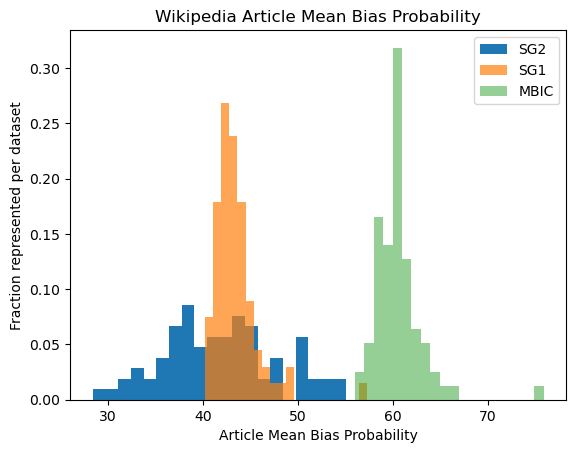

In [95]:

(wiki_sentence_dataset.groupby("article_title")["bias_probability"].mean()*100).sort_values(ascending=True).plot(
    title='Wikipedia Article Mean Bias Probability', kind='hist', bins=20, density=True
)


(sg1_wiki_sentence_dataset.groupby("article_title")["bias_probability"].mean()*100).sort_values(ascending=True).plot(
    kind='hist', bins=20, alpha=0.7, density=True
)


(mbic_wiki_sentence_dataset.groupby("article_title")["bias_probability"].mean()*100).sort_values(ascending=True).plot(
    kind='hist', bins=20, alpha=0.5, density=True
)

plt.legend(['SG2', 'SG1', 'MBIC'])
plt.xlabel("Article Mean Bias Probability")
plt.ylabel("Fraction represented per dataset")
plt.show()

This histogram shows the frequency with which bias percentages appeared in each set of results. SG2 had a relatively flat and wide representation, meaning it saw a greater difference between the most and least biased articles. SG1 had a comparable mean to SG2, but had the least range of the three. MBIC's results appear to the right of the other two data sets, indicating higher confidence that bias exists across the board.

# Conclusion

We were able to accomplish thorough bias analysis with respect to our selection of Wikipedia articles.

- We trained a model on the canonical "SG2" data set to detect bias.
    - SG2 contains sentences pulled from news articles across several sources and labels them for bias.
    - Validation steps resulted in a ROC-AUC score of 0.809.
- We scraped Wikipedia for articles, then measured them using the model we trained.
    - 79 valid articles were found.
- We assigned each Wikipedia article a `bias_score` equal to the number of sentences flagged for bias divided by the total number of sentences.
    - Articles ranged from 0.155 to 0.76, meaning most articles contained at least some sentences that might reflect bias.
    - This suggests Wikipedia's level of bias varies from article to article.
- We also trained two additional models on other data sets, "SG1" and "MBIC," for comparison.
    - Each data set is identical except that SG1's sentences were labeled by a panel of experts, while MBIC's labels were crowdsourced.
    - To keep the comparison as close as possible, SG2 was not used for this section, as it contains additional sentences.
    - We did exploratory analysis to find differences in the way the two sets of data labeled bias.
        - MBIC was generally more sensitive to bias, especially bias in sources perceived as left-leaning.
    - After running the same preprocessing and training that SG2 went through, we determined ROC-AUC scores:
        - SG1 scored about 0.75
        - MBIC scored about 0.73
    - Against the Wikipedia articles, SG2 thought about 11% were biased, while MBIC found bias in over 90% of them!
        - This was much greater than the difference in the training data EDA would suggest.

## New Conclusion?:

---

This project aimed to investigate and quantify linguistic bias in Wikipedia articles using two different supervised learning models trained on labeled datasets: MBIC and SG1. Data was initially gathered from an existing media bias corpus and enhanced with Wikipedia article text, accessed and parsed through a scraping pipeline (**Task 1: Collect data**). After preparing and aligning the MBIC and SG1 datasets, exploratory data analysis was performed to compare label agreement, outlet discrepancies, and political leanings in bias labeling (**Task 2: Conduct EDA**).

Both datasets were cleaned and preprocessed by removing ambiguous labels, creating bias-matching lexicon features, and appending article headlines to provide contextual completeness. Each model—SG1 and MBIC—was trained using a logistic regression pipeline, incorporating TF-IDF vectorization and numerical features such as lexicon match count (**Task 3: Conduct supervised learning**).

The SG1 model achieved an AUC-ROC score of `0.7488`, with a precision-recall balance favoring non-biased classification. The MBIC model reached an AUC-ROC score of `0.7268`, but with significantly higher sensitivity toward biased predictions. When applied to Wikipedia articles, MBIC labeled `96%` of sentences as biased, while SG1 flagged only `11%`. This confirmed the hypothesis that MBIC is stricter in detecting bias.

A sentence-level prediction function was implemented to assign bias scores across full Wikipedia articles (**Task 4: Create a prediction function**). These scores were then aggregated to assess article-level bias (**Task 4 continued: Scale results by article length**). Using this framework, comparisons were made between the most and least biased articles according to each model (**BONUS: Consider which articles are more or less biased**). MBIC tended to assign higher bias probabilities across all topics, while SG1 showed more restraint and nuance in its labeling.

---

Ultimately, we met all the objectives of the task:
- We sourced and processed Wikipedia data (**Task 1**).
- We performed in-depth exploratory analysis of text bias labeling (**Task 2**).
- We trained two supervised classifiers and built pipelines capable of predicting bias on individual sentences (**Task 3**).
- We developed a sentence-level prediction function that scores full Wikipedia articles (**Task 4**).
- We analyzed the articles deemed most and least biased, identifying shared patterns like political or cultural sensitivity (**BONUS**).

These findings suggest that bias labeling is highly subjective and varies significantly based on the labeling source. MBIC's aggressive stance may highlight subtle linguistic cues, while SG1 may emphasize more overt expressions of bias.

---